In [1]:
!pip install mysql-connector-python

In [2]:
# import required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
pd.set_option('display.max_columns',None)
import os
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

## 1 - Collect or load data.

In [3]:
import mysql.connector
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")
connection = mysql.connector.connect(host="18.136.157.135",
                                    user="dm_usdata_sql",
                                    password="37z<49REb&mKnl4AV!vJ",
                                    database="project_service_data",
                                    use_pure=True)

In [4]:
cursor=connection.cursor()
cursor.execute("show databases")
for i in cursor:
    print(i)

('information_schema',)
('project_service_data',)


In [5]:
table= pd.read_sql_query("show tables",connection)
print(table)

  Tables_in_project_service_data
0                   service_data


In [6]:
df = pd.read_sql_query("select * from service_data",connection)
df

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
...,...,...,...,...,...,...,...
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL


## 2. Domain Analysis – Spare Parts Inventory Forecasting

### Business Domain:
This project falls under the **Automobile After-Sales Service** and **Inventory Management** domain. Automobile service centers often struggle with optimizing their inventory of spare parts. Overstocking leads to high holding costs, while understocking results in customer dissatisfaction and delayed services.

### Problem Statement:
Service centers face difficulty in maintaining the right inventory of spare parts, resulting in high inventory costs and spare part unavailability. The goal is to build a predictive model to help forecast the demand for specific spare parts in advance, enabling Just-In-Time (JIT) inventory planning.

### Objective:
To develop a **predictive machine learning model** that can classify the type of spare part required (`invoice_line_text`) based on historical service data such as:
- Vehicle model
- Kilometers driven
- Service date
- Customer or business partner

This model will help service centers:
- Reduce unnecessary inventory costs
- Avoid delays due to unavailable spare parts
- Improve overall service efficiency

### Machine Learning Problem Type:
This is a **Multiclass Classification** problem because the target variable (`invoice_line_text`) contains more than two categories (e.g., ENGINE OIL, DISC OIL, CLUTCH CABLE, etc.).

### Target Variable:
- `invoice_line_text` – the name of the spare part required in the service.

### Input Features (Examples):
- `vehicle_model`
- `current_km_reading`
- `invoice_date`
- `job_card_date`
- `vehicle_no`
- `business_partner_name`

### Potential ML Models:
- Logistic Regression (Multinomial)
- Random Forest Classifier
- XGBoost Classifier
- LightGBM Classifier
- MLPClassifier (Neural Network)

### Expected Outcome:
A model that can accurately predict which spare part is likely to be needed during a service, enabling proactive and cost-effective inventory planning.


## 3. Basic Check

In [7]:
print("shape of data is:", df.shape)

shape of data is: (28482, 7)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [9]:
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [10]:
df.tail()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL
28481,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,AIR FILTER


In [11]:
df.business_partner_name.value_counts()

business_partner_name
venkXXXXXXXXXX    424
manjXXXXXXXXXX    362
prasXXXXXXXXXX    328
shivXXXXXXXXXX    314
chanXXXXXXXXXX    312
                 ... 
SUMAXXXXXXXXXX      1
VIRUXXXXXXXXXX      1
ARGHXXXXXXXXXX      1
revaXXXXXXXXXX      1
a veXXXXXXXXXX      1
Name: count, Length: 1010, dtype: int64

In [12]:
df.vehicle_no.value_counts()

vehicle_no
KA53EVXXXX    1313
KA53EQXXXX    1296
KA53ETXXXX    1238
KA53ERXXXX    1187
KA53ESXXXX    1129
              ... 
AP16BXXXXX       1
KA11ELXXXX       1
KA53S9XXXX       1
KA53V3XXXX       1
KA03MFXXXX       1
Name: count, Length: 846, dtype: int64

In [13]:
df.vehicle_model.value_counts()

vehicle_model
BAJAJ PULSAR 150            8633
BAJAJ AVENGER STREET 220    4212
BAJAJ PULSAR 220            2655
BAJAJ PULSAR 180            2252
BAJAJ PULSAR NS 200         2204
BAJAJ CT 100                1432
BAJAJ DISCOVER 125          1346
BAJAJ AVENGER STREET        1112
BAJAJ PLATINA                844
BAJAJ V150                   686
BAJAJ DISCOVER               679
BAJAJ PULSAR LS135           520
BAJAJ PULSAR AS 200          421
BAJAJ PULSAR NS 160          364
BAJAJ PULSAR RS 200          322
BAJAJ DISCOVER 150           284
BAJAJ AVENGER STREET 180     122
BAJAJ DISCOVER 135           115
BAJAJ V125                    95
BAJAJ V                       54
BAJAJ CALIBER                 40
BAJAJ XCD 125                 27
BAJAJ V15                     23
BAJAJ XCD 135                 13
WAVE                          10
BAJAJ DOMINAR 400 ABS          7
BAJAJ WIND 125                 6
BAJAJ BOXER CT                 4
Name: count, dtype: int64

In [14]:
df

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
...,...,...,...,...,...,...,...
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL


### i. Handling Duplicate Values

In [15]:
# checking duplicated rows
print("duplicated values in data set", df.duplicated().sum())

duplicated values in data set 383


In [16]:
df[df.duplicated(keep=False)]

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
24,03-06-17,31-05-17,MAYAXXXXXXXXXX,KA05JGXXXX,BAJAJ PULSAR 220,25000,DISC PAD
40,03-06-17,31-05-17,MAYAXXXXXXXXXX,KA05JGXXXX,BAJAJ PULSAR 220,25000,DISC PAD
41,05-06-17,01-06-17,srivXXXXXXXXXX,KA02EWXXXX,BAJAJ PULSAR 150,41458,BRAKE ADJUSTMENT
43,05-06-17,01-06-17,srivXXXXXXXXXX,KA02EWXXXX,BAJAJ PULSAR 150,41458,BRAKE ADJUSTMENT
577,13-06-17,13-06-17,subhXXXXXXXXXX,KA53J9XXXX,BAJAJ AVENGER STREET 220,14484,SILENCER
...,...,...,...,...,...,...,...
28318,04-01-19,04-01-19,ALOKXXXXXXXXXX,KA53EWXXXX,BAJAJ CT 100,27786,BRAKE SHOE
28343,04-01-19,04-01-19,yeshXXXXXXXXXX,KA40ECXXXX,BAJAJ PULSAR 220,11541,DISC PAD
28346,04-01-19,04-01-19,yeshXXXXXXXXXX,KA40ECXXXX,BAJAJ PULSAR 220,11541,DISC PAD
28444,05-01-19,05-01-19,ashoXXXXXXXXXX,KA53EPXXXX,BAJAJ PULSAR 150,22413,BRAKE SHOE


In [17]:
# we drop duplicate values
df.drop_duplicates(inplace=True)
df

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
...,...,...,...,...,...,...,...
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL


### ii. Handling Null values

In [18]:
df.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        5
dtype: int64

In [19]:
# dropping null values bcz they very low
df.dropna(inplace=True)

In [20]:
df.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        0
dtype: int64

### iii. Handling Date Time variable

In [21]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True)
df['job_card_date'] = pd.to_datetime(df['job_card_date'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28094 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   invoice_date           28094 non-null  datetime64[ns]
 1   job_card_date          28094 non-null  datetime64[ns]
 2   business_partner_name  28094 non-null  object        
 3   vehicle_no             28094 non-null  object        
 4   vehicle_model          28094 non-null  object        
 5   current_km_reading     28094 non-null  object        
 6   invoice_line_text      28094 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 1.7+ MB


In [22]:
df.describe()

,invoice_date,job_card_date
count,28094,28094
mean,2018-04-20 22:00:22.040293376,2018-04-20 21:10:20.459884544
min,2017-05-30 00:00:00,2017-05-30 00:00:00
25%,2017-11-28 00:00:00,2017-11-28 00:00:00
50%,2018-05-10 00:00:00,2018-05-10 00:00:00
75%,2018-09-21 00:00:00,2018-09-21 00:00:00
max,2019-01-06 00:00:00,2019-01-06 00:00:00


In [23]:
df.describe(include='O')

,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
count,28094,28094,28094,28094,28094
unique,1010,846,28,3474,503
top,venkXXXXXXXXXX,KA53EVXXXX,BAJAJ PULSAR 150,0,ENGINE OIL
freq,416,1299,8500,824,3780


In [24]:
# Check which values are non-numeric
non_numeric_values = df[~df['current_km_reading'].str.replace(',', '').str.strip().str.isnumeric()]['current_km_reading'].unique()

print("Non-numeric or categorical values:")
print(non_numeric_values)

Non-numeric or categorical values:
[]


In [25]:
# Convert to numeric (removing commas and spaces), invalid parsing will turn 
# into NaN
df['current_km_reading'] = pd.to_numeric(
    df['current_km_reading'].str.replace(',', '').str.strip(),
    errors='coerce'
).astype('Int64')  # Use 'Int64' for nullable integers

## 3. EDA(Exploratory data analysis)

### i. Univariate analysis

### a. Date and Time variables

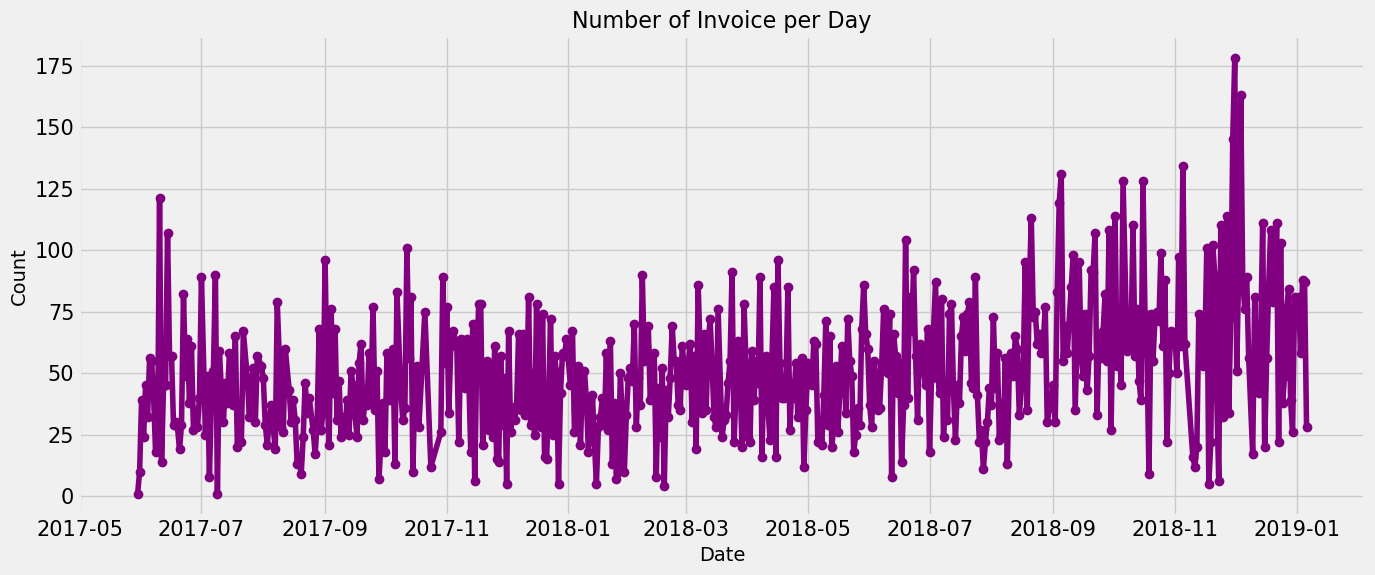

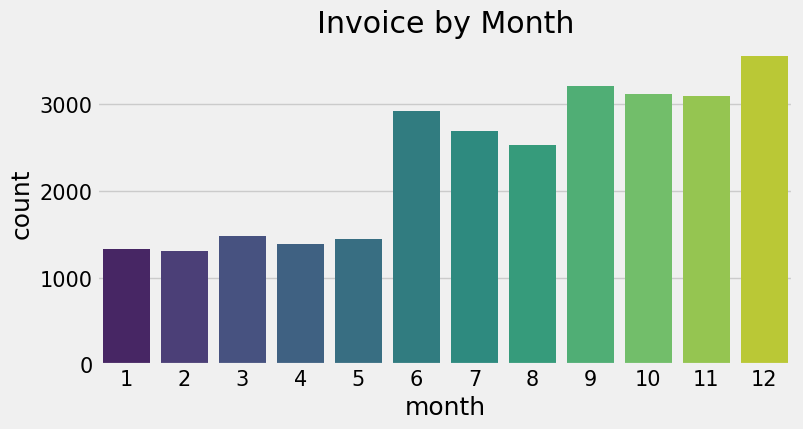

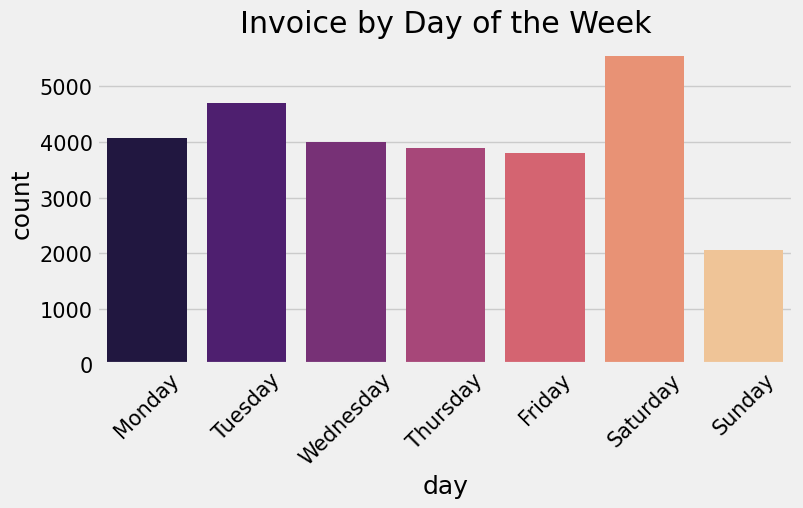

In [26]:
# Ensure your column is in datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# 1. Plot count of entries per day (line plot)
daily_counts = df['invoice_date'].value_counts().sort_index()

plt.figure(figsize=(14,6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', color='purple')
plt.title("Number of Invoice per Day", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Extract and analyze parts of the date
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day'] = df['invoice_date'].dt.day_name()   # For day of the week

# 3. Count by Month
plt.figure(figsize=(8,4))
sns.countplot(x='month', data=df, palette='viridis')
plt.title("Invoice by Month")
plt.show()

# 4. Count by Day of Week
plt.figure(figsize=(8,4))
sns.countplot(x='day', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette='magma')
plt.title("Invoice by Day of the Week")
plt.xticks(rotation=45)
plt.show()

# Optional: Drop added columns if not needed later
df.drop(['year', 'month', 'day'], axis=1, inplace=True)


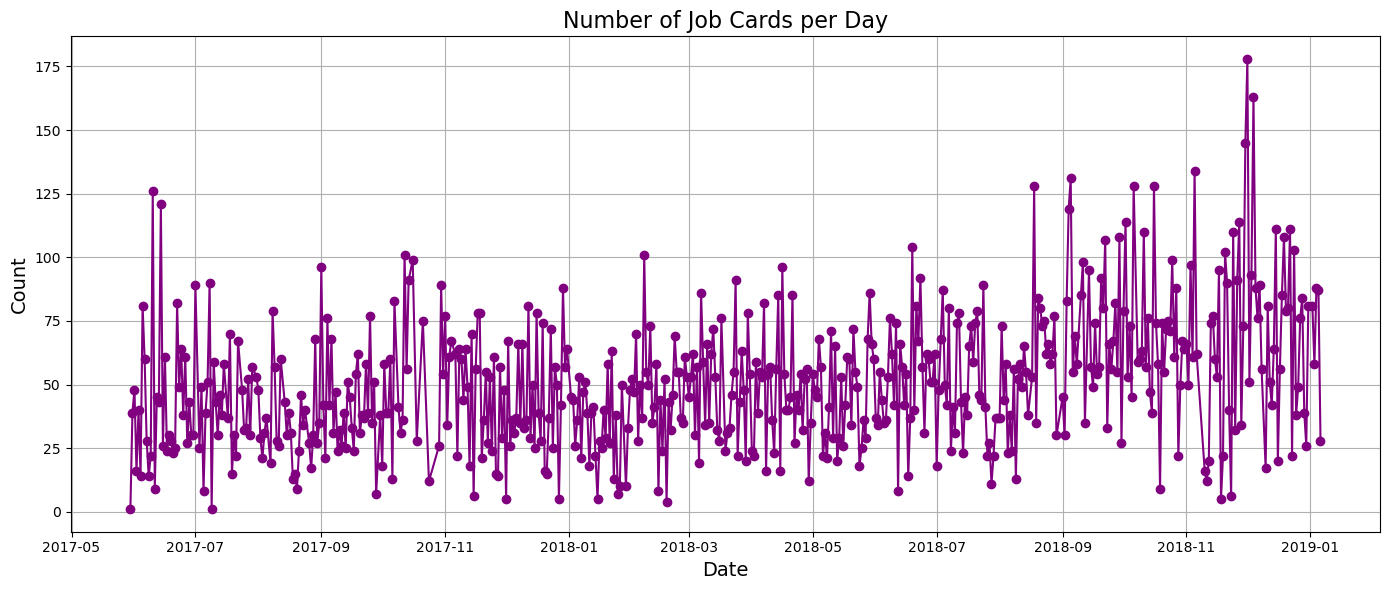

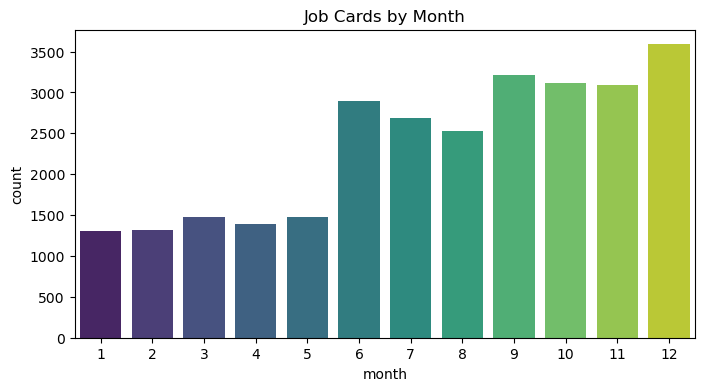

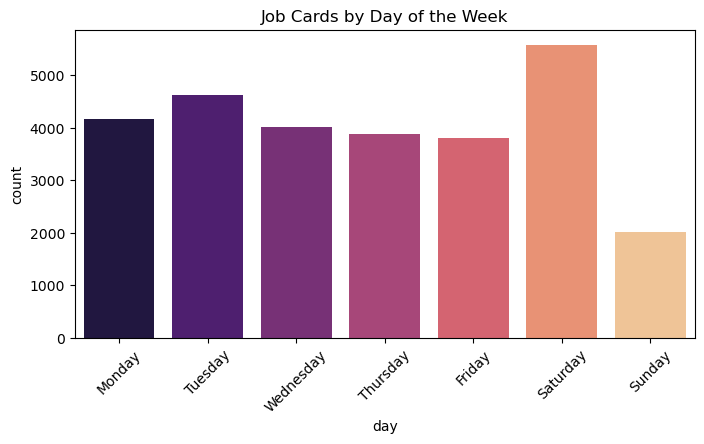

In [27]:
# Ensure your column is in datetime format
df['job_card_date'] = pd.to_datetime(df['job_card_date'])

# 1. Plot count of entries per day (line plot)
daily_counts = df['job_card_date'].value_counts().sort_index()

plt.figure(figsize=(14,6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', color='purple')
plt.title("Number of Job Cards per Day", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Extract and analyze parts of the date
df['year'] = df['job_card_date'].dt.year
df['month'] = df['job_card_date'].dt.month
df['day'] = df['job_card_date'].dt.day_name()   # For day of the week

# 3. Count by Month
plt.figure(figsize=(8,4))
sns.countplot(x='month', data=df, palette='viridis')
plt.title("Job Cards by Month")
plt.show()

# 4. Count by Day of Week
plt.figure(figsize=(8,4))
sns.countplot(x='day', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette='magma')
plt.title("Job Cards by Day of the Week")
plt.xticks(rotation=45)
plt.show()

# Optional: Drop added columns if not needed later
df.drop(['year', 'month', 'day'], axis=1, inplace=True)


### b. Categorical Variables

In [26]:
cat_cols = [col for col in df.columns if df[col].dtypes == ('object')]

In [27]:
cat_cols

['business_partner_name', 'vehicle_no', 'vehicle_model', 'invoice_line_text']

Unique values of business_partner_name
venkXXXXXXXXXX    416
manjXXXXXXXXXX    354
prasXXXXXXXXXX    320
chanXXXXXXXXXX    311
raviXXXXXXXXXX    307
                 ... 
ARGHXXXXXXXXXX      1
SUMAXXXXXXXXXX      1
a veXXXXXXXXXX      1
revaXXXXXXXXXX      1
VIRUXXXXXXXXXX      1
Name: count, Length: 1010, dtype: int64


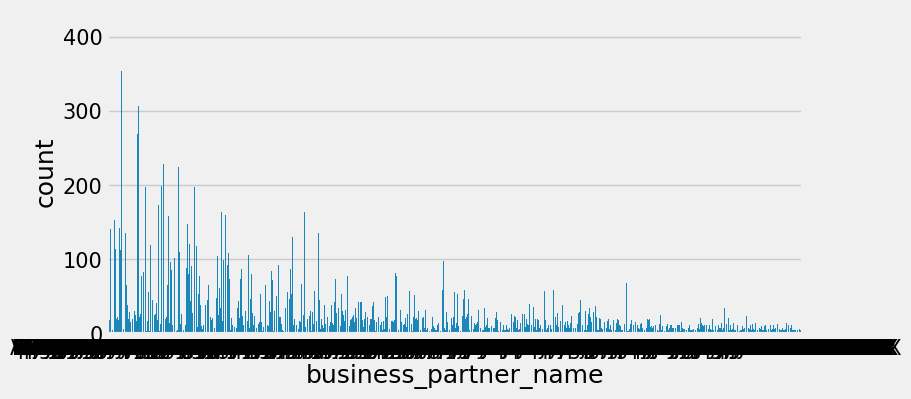

-------------------------------------------------------------------------------------
Unique values of vehicle_no
KA53EVXXXX    1299
KA53EQXXXX    1273
KA53ETXXXX    1205
KA53ERXXXX    1181
KA53ESXXXX    1114
              ... 
AP04BVXXXX       1
KA04EUXXXX       1
AP16BXXXXX       1
NS200XXXX        1
KA03MFXXXX       1
Name: count, Length: 846, dtype: int64


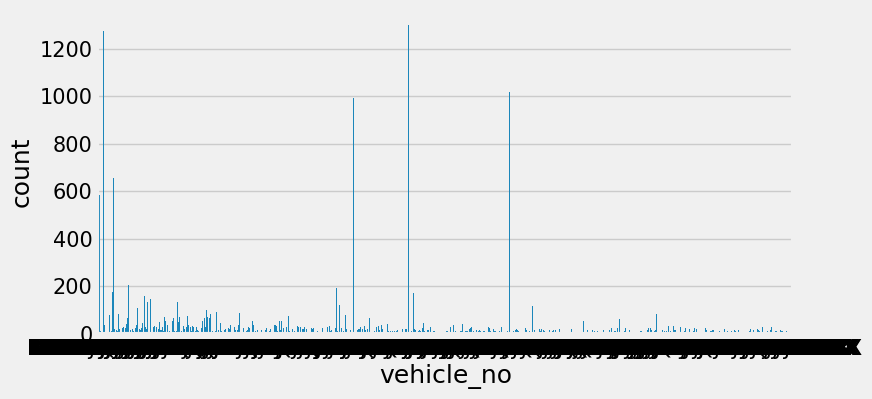

-------------------------------------------------------------------------------------
Unique values of vehicle_model
BAJAJ PULSAR 150            8500
BAJAJ AVENGER STREET 220    4162
BAJAJ PULSAR 220            2608
BAJAJ PULSAR 180            2238
BAJAJ PULSAR NS 200         2180
BAJAJ CT 100                1401
BAJAJ DISCOVER 125          1340
BAJAJ AVENGER STREET        1103
BAJAJ PLATINA                830
BAJAJ V150                   684
BAJAJ DISCOVER               659
BAJAJ PULSAR LS135           517
BAJAJ PULSAR AS 200          413
BAJAJ PULSAR NS 160          361
BAJAJ PULSAR RS 200          310
BAJAJ DISCOVER 150           279
BAJAJ AVENGER STREET 180     121
BAJAJ DISCOVER 135           113
BAJAJ V125                    92
BAJAJ V                       53
BAJAJ CALIBER                 40
BAJAJ XCD 125                 27
BAJAJ V15                     23
BAJAJ XCD 135                 13
WAVE                          10
BAJAJ DOMINAR 400 ABS          7
BAJAJ WIND 125           

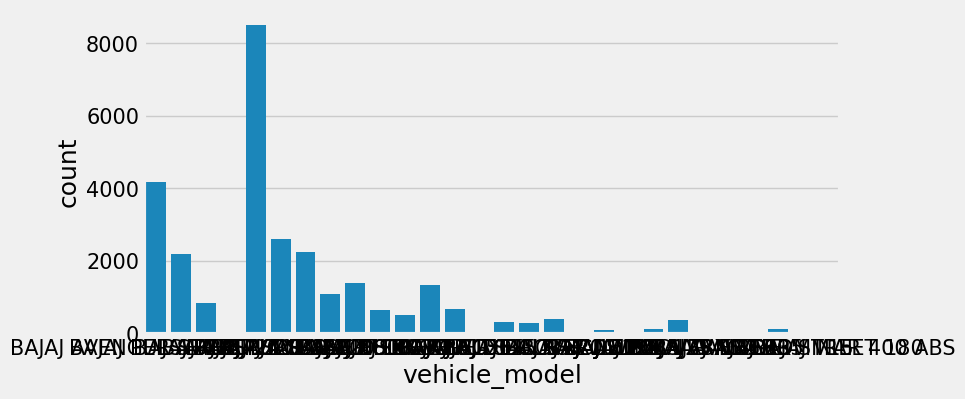

-------------------------------------------------------------------------------------
Unique values of invoice_line_text
ENGINE OIL           3780
CHAIN LUBRICATION    3417
GENERAL SERVICE      2132
AIR FILTER           1698
3M OIL               1615
                     ... 
CLUTCH ROLLERS          1
CLUTCH SPRING KIT       1
CLUTCH SHOE             1
U BUSH                  1
HELMET                  1
Name: count, Length: 503, dtype: int64


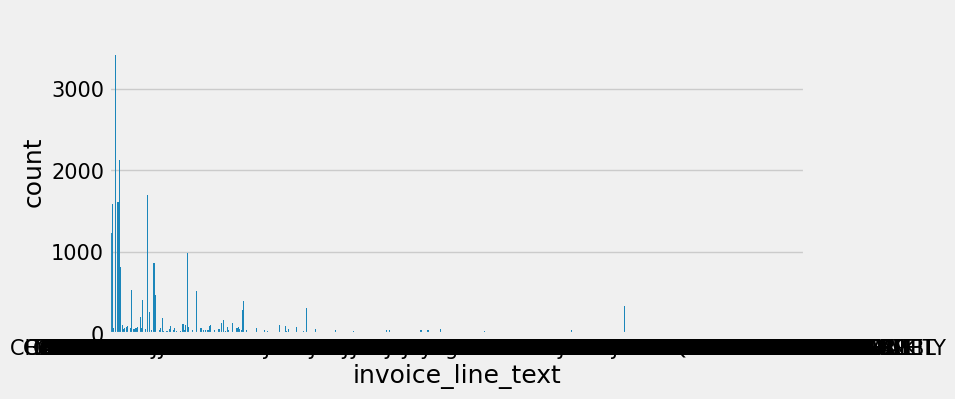

-------------------------------------------------------------------------------------


In [28]:

for col in cat_cols:
    plt.figure(figsize=(8,4))
    print(f"Unique values of", df[col].value_counts())
    sns.countplot(x=col, data=df)
    plt.show()
    print("-------------------------------------------------------------------------------------")

### c. Numeric Columns

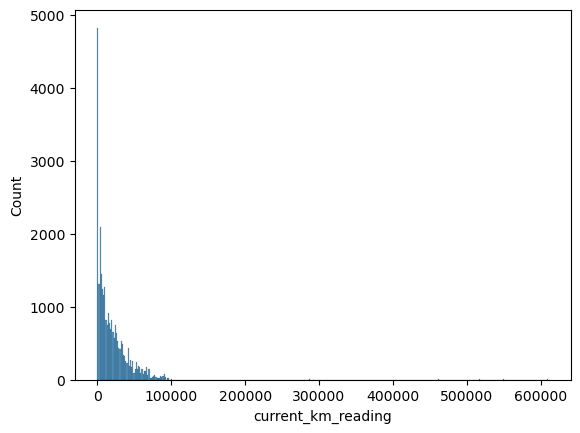

In [31]:
sns.histplot(x=df['current_km_reading'], data=df)
plt.show()

### ii. Bivariate Analysis

#### a. Date and Time variables

<Figure size 1400x700 with 0 Axes>

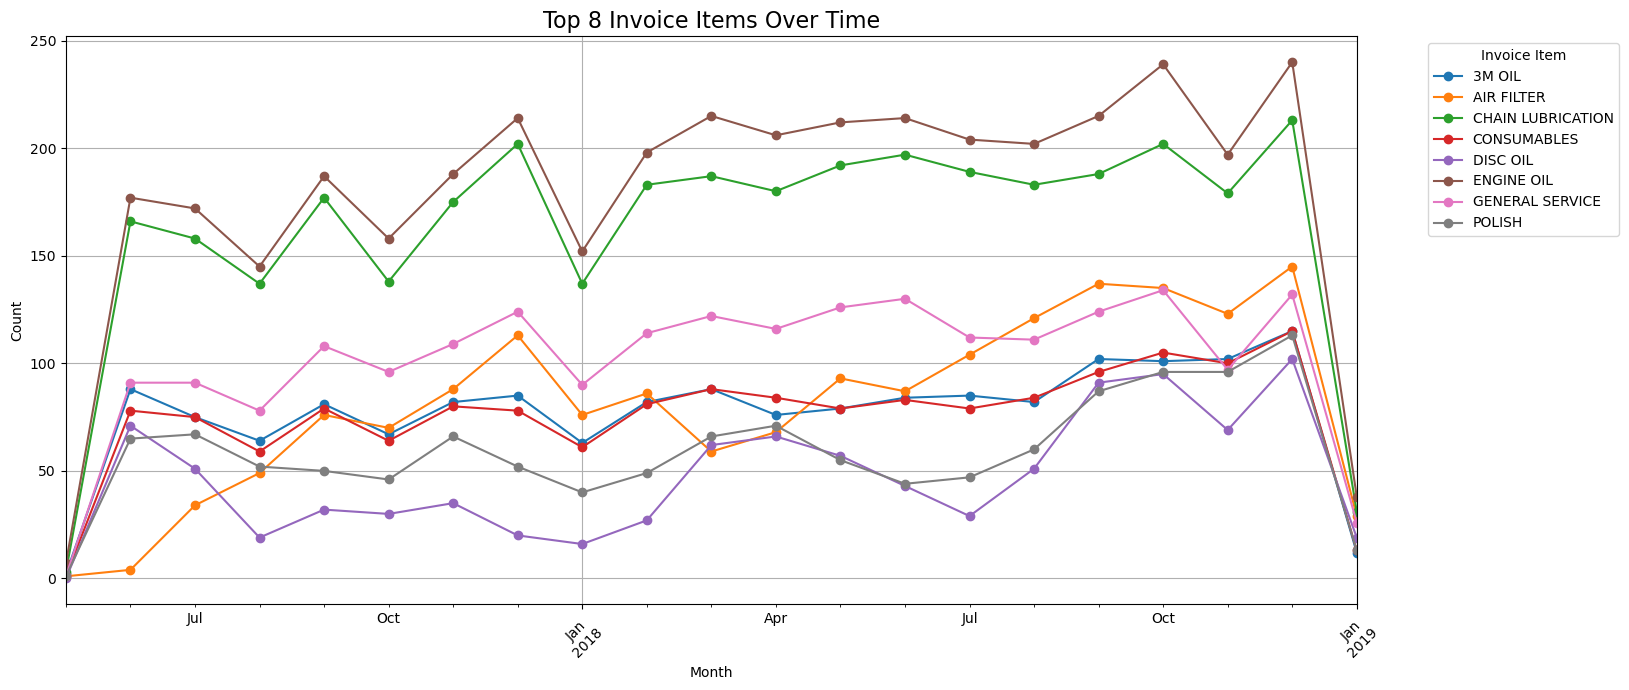

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Work on a copy to avoid modifying the original DataFrame
df_copy = df.copy()

# Convert to datetime if not already
df_copy['job_card_date'] = pd.to_datetime(df_copy['job_card_date'])

# Extract month for trend analysis
df_copy['month'] = df_copy['job_card_date'].dt.to_period('M')

# Find top N most frequent invoice_line_text categories
top_n = 8  # Change to 10, 5, etc. as needed
top_items = df_copy['invoice_line_text'].value_counts().nlargest(top_n).index

# Filter the DataFrame
filtered_df = df_copy[df_copy['invoice_line_text'].isin(top_items)]

# Group and plot
monthly_counts = filtered_df.groupby(['month', 'invoice_line_text']).size().unstack().fillna(0)

plt.figure(figsize=(14,7))
monthly_counts.plot(marker='o', figsize=(14,7))
plt.title(f"Top {top_n} Invoice Items Over Time", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Invoice Item", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<Figure size 1400x700 with 0 Axes>

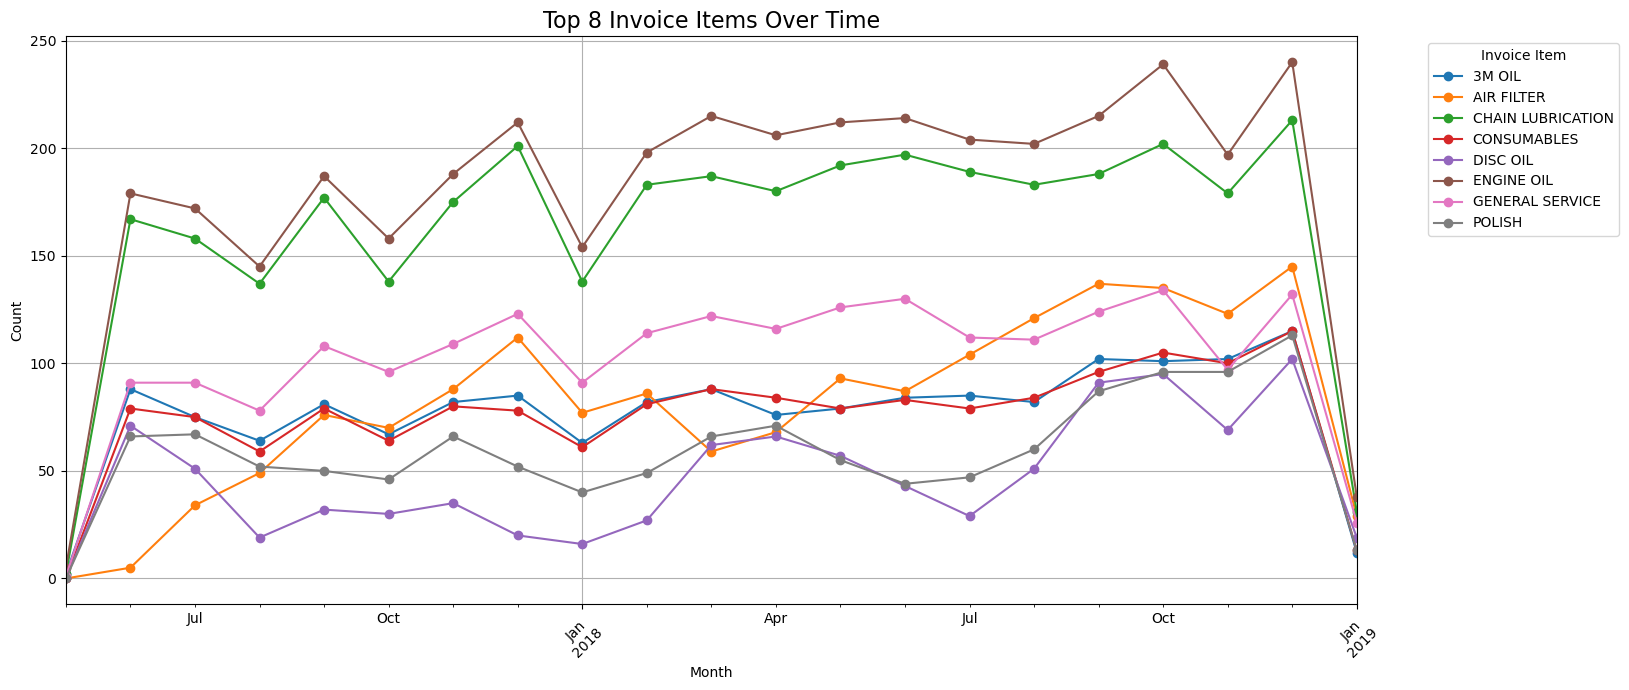

In [33]:
# Work on a copy to avoid modifying the original DataFrame
df_copy = df.copy()

# Convert to datetime if not already
df_copy['invoice_date'] = pd.to_datetime(df_copy['invoice_date'])

# Extract month for trend analysis
df_copy['month'] = df_copy['invoice_date'].dt.to_period('M')

# Find top N most frequent invoice_line_text categories
top_n = 8  # Change to 10, 5, etc. as needed
top_items = df_copy['invoice_line_text'].value_counts().nlargest(top_n).index

# Filter the DataFrame
filtered_df = df_copy[df_copy['invoice_line_text'].isin(top_items)]

# Group and plot
monthly_counts = filtered_df.groupby(['month', 'invoice_line_text']).size().unstack().fillna(0)

plt.figure(figsize=(14,7))
monthly_counts.plot(marker='o', figsize=(14,7))
plt.title(f"Top {top_n} Invoice Items Over Time", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Invoice Item", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### b. Categorical columns

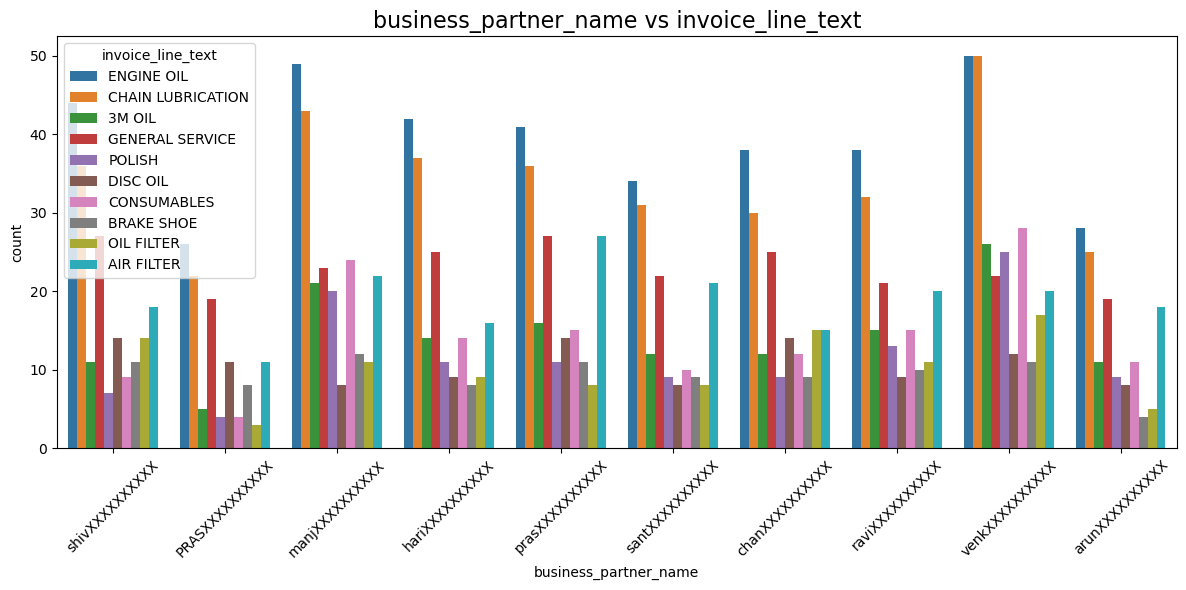

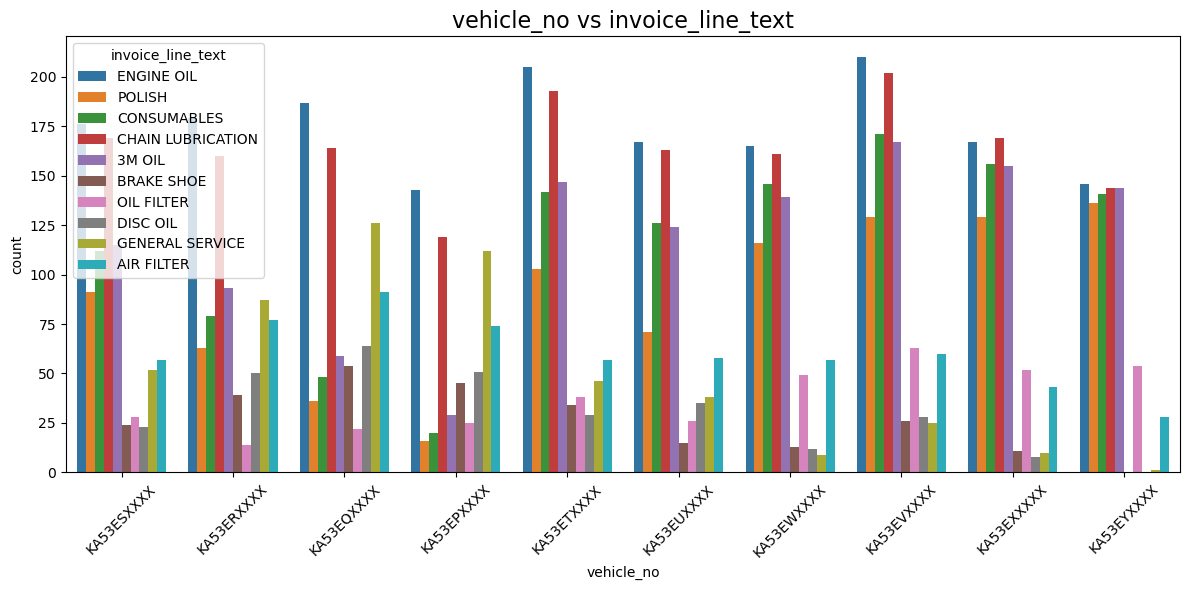

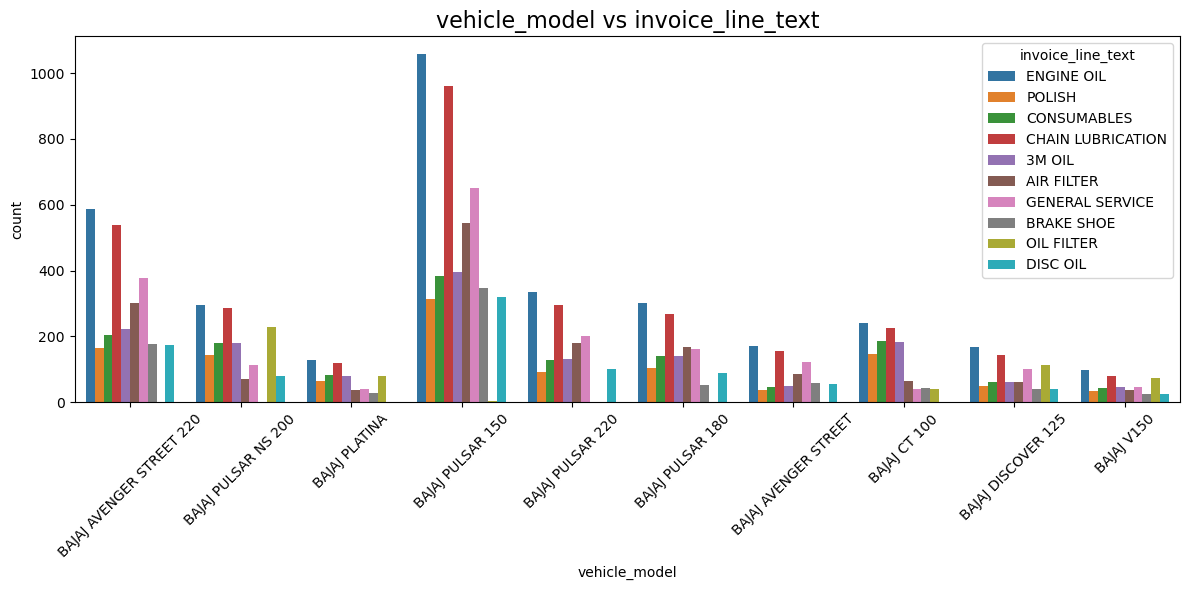

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != 'invoice_line_text']  # avoid self-comparison

# Parameters for top values
top_n = 10
top_m = 10

# Get top invoice_line_text values
top_texts = df['invoice_line_text'].value_counts().index[:top_m]

# Loop over each categorical column
for col in cat_cols:
    # Get top categories for current column
    top_categories = df[col].value_counts().index[:top_n]

    # Filter DataFrame
    filtered_df = df[
        df[col].isin(top_categories) &
        df['invoice_line_text'].isin(top_texts)
    ]

    # Skip if filtered data is too small
    if filtered_df.empty:
        continue

    # Plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=filtered_df, x=col, hue='invoice_line_text')
    plt.title(f'{col} vs invoice_line_text', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### c. Numerical columns

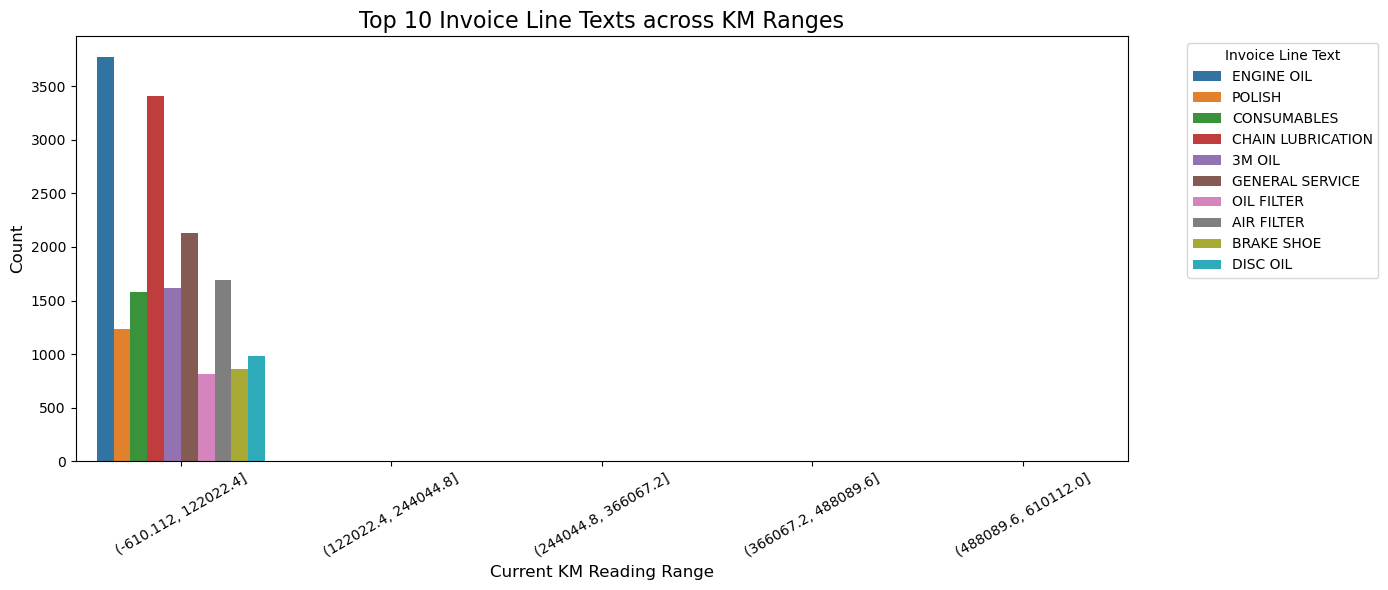

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numeric type
df['current_km_reading'] = pd.to_numeric(df['current_km_reading'], errors='coerce')

# Bin KM readings
df['km_bin'] = pd.cut(df['current_km_reading'], bins=5)

# Filter to top 10 invoice_line_texts only
top_texts = df['invoice_line_text'].value_counts().index[:10]
filtered_df = df[df['invoice_line_text'].isin(top_texts)]

# Plot
plt.figure(figsize=(14, 6))
sns.countplot(data=filtered_df, x='km_bin', hue='invoice_line_text')

plt.title('Top 10 Invoice Line Texts across KM Ranges', fontsize=16)
plt.xlabel('Current KM Reading Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=30)
plt.legend(title='Invoice Line Text', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
df.drop('km_bin', axis=1, inplace=True)

### iii. Multivariate Analysis

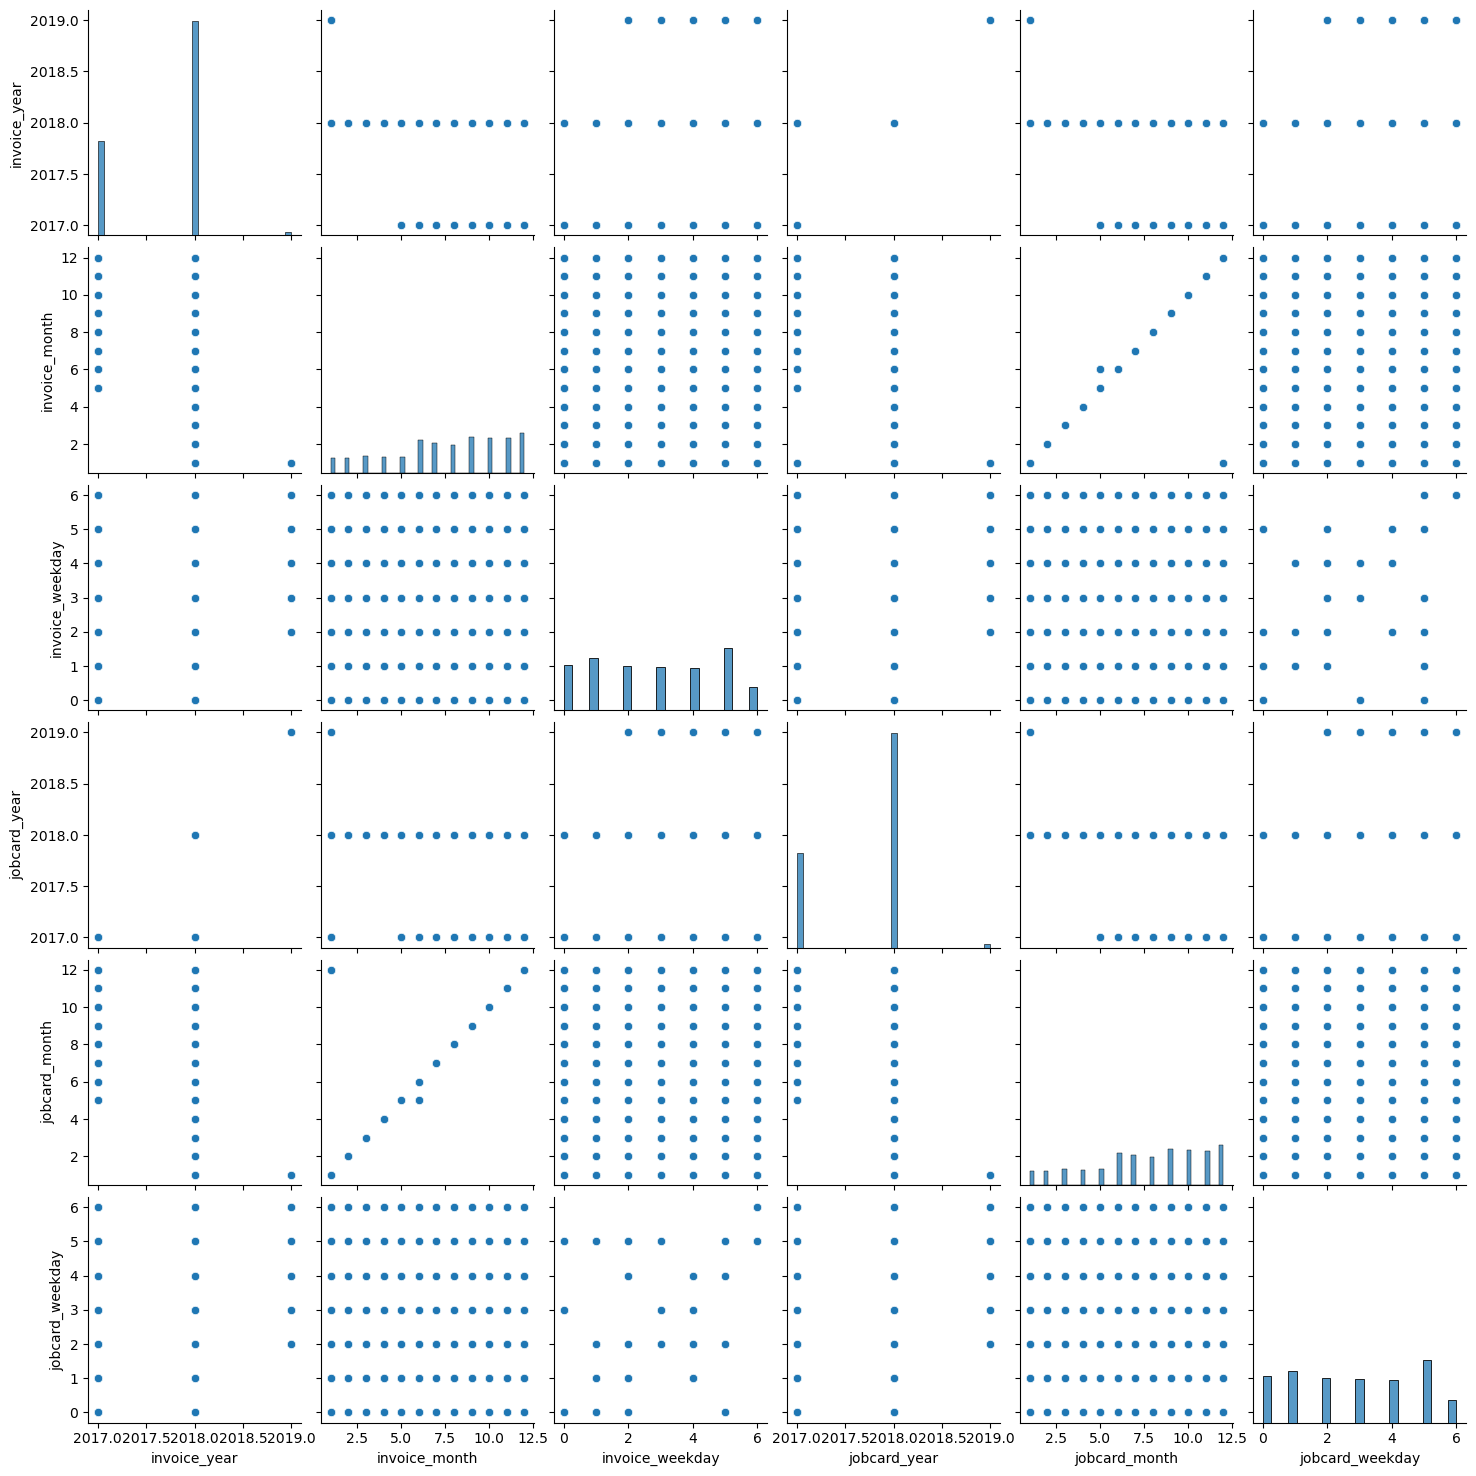

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Work on a copy to avoid modifying the original df
df_copy = df.copy()

# Ensure the columns are datetime type
df_copy['invoice_date'] = pd.to_datetime(df_copy['invoice_date'])
df_copy['job_card_date'] = pd.to_datetime(df_copy['job_card_date'])

# Extract features from invoice_date
df_copy['invoice_year'] = df_copy['invoice_date'].dt.year
df_copy['invoice_month'] = df_copy['invoice_date'].dt.month
df_copy['invoice_day'] = df_copy['invoice_date'].dt.day
df_copy['invoice_weekday'] = df_copy['invoice_date'].dt.weekday

# Extract features from job_card_date
df_copy['jobcard_year'] = df_copy['job_card_date'].dt.year
df_copy['jobcard_month'] = df_copy['job_card_date'].dt.month
df_copy['jobcard_day'] = df_copy['job_card_date'].dt.day
df_copy['jobcard_weekday'] = df_copy['job_card_date'].dt.weekday

# Select only columns that actually exist
cols_to_plot = [
    'invoice_year', 'invoice_month', 'invoice_weekday',
    'jobcard_year', 'jobcard_month', 'jobcard_weekday'
]

# Drop rows with missing values in these columns
plot_df = df_copy[cols_to_plot].dropna()

# Create pairplot
sns.pairplot(plot_df)
plt.show()


## 5. Data Preprocessing

### i. Handling Output Column

In [29]:
df['invoice_line_text'].value_counts()

invoice_line_text
ENGINE OIL           3780
CHAIN LUBRICATION    3417
GENERAL SERVICE      2132
AIR FILTER           1698
3M OIL               1615
                     ... 
CLUTCH ROLLERS          1
CLUTCH SPRING KIT       1
CLUTCH SHOE             1
U BUSH                  1
HELMET                  1
Name: count, Length: 503, dtype: int64

- Target contains names of different spare parts as well as other miscellaneous things such as service charge, labour, cleaning, etc.
- We are interested in parts/items/consumables only. Only parts/items/consumbables need to procured from manufacturer, so requirement forecasting has to be done only for these parts.
- Next we do some pre-processing where we keep things that are only required and remove the rest of them.

In [27]:
labels_to_delete = ['CHARGE', 'INSURANCE', 'PAYMENT', 'REGISTER', 'ADJUSTMENT', 'NUMBER PLATE','PACKING',
                    'REMOVAL', 'THREADING', 'CLEANING', 'FEES', 'REBORE', 'PUNCHER', 'EX SHOW ROOM', 'CRANK RESET',
                    'DENT', 'RC CARD', 'TAX', 'ENGINE WORK','SERVICE', 'CHECK', 'LABOUR', 'POLISH','TOP UP','TOPUP',
                    'LOGO','HAND GLOUSE', 'NO PLATE', 'WELDING','WIELDING','WASHING','OVERHUAL','OVERHAUL','STICKER',
                    'ENGINE RE CONDITION','STAY']

In [28]:
df1=df.copy()

for index, text in df1['invoice_line_text'].items():
    if text == 'SERVICE AND ONE WAY CLUTCH BUSH KIT':
        print('Changed the text from "SERVICE AND ONE WAY CLUTCH BUSH KIT" to "ONE WAY CLUTCH BUSH KIT"')
        df1.loc[index, 'invoice_line_text'] = 'ONE WAY CLUTCH BUSH KIT'

    if text == 'tyre':
        print('Changed the text from "tyre" to "TYRE"')
        df1.loc[index, 'invoice_line_text'] = 'TYRE'

    if text == 'TYRE REPLACEMENT':
        print('Changed the text from "TYRE REPLACEMENT" to "TYRE"')
        df1.loc[index, 'invoice_line_text'] = 'TYRE'

    if text == 'VISIOR WITH LABOUR':
        print('Changed the text from "VISIOR WITH LABOUR" to "VISIOR"')
        df1.loc[index, 'invoice_line_text'] = 'VISIOR'

    if text.strip() == 'PETROL':
        print('Deleting line that has PETROL only')
        df1.drop(index=index, inplace=True)

    if text == 'clutch cable':
        print('Changed the text from "clutch cable" to "CLUTCH CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'

    if text == 'Clutch cable':
        print('Changed the text from "Clutch cable" to "CLUTCH CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'

    if text == 'Clutch CABLE':
        print('Changed the text from "Clutch CABLE" to "CLUTCH CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH CABLE'

    if text == 'CLUTCH REPALCEMENT':
        print('Changed the text from "CLUTCH REPALCEMENT" to "CLUTCH"')
        df1.loc[index, 'invoice_line_text'] = 'CLUTCH'

    if text == 'DOOM REPLACEMENT':
        print('Changed the text from "DOOM REPLACEMENT" to "DOOM"')
        df1.loc[index, 'invoice_line_text'] = 'DOOM'

    if text == 'handle weight':
        print('Changed the text from "handle weight" to "HANDLE WEIGHT"')
        df1.loc[index, 'invoice_line_text'] = 'HANDLE WEIGHT'

    if text == 'INTAKE':
        print('Changed the text from "INTAKE" to "AIR INTAKE"')
        df1.loc[index, 'invoice_line_text'] = 'AIR INTAKE'

    if text == 'SPPEDOMETER CABLE':
        print('Changed the text from "SPPEDOMETER CABLE" to "SPPEDOMETER CABLE"')
        df1.loc[index, 'invoice_line_text'] = 'SPPEDOMETER CABLE'

    if text == 'SELF REALY':
        print('Changed the text from "SELF REALY" to "SELF RELAY"')
        df1.loc[index, 'invoice_line_text'] = 'SELF RELAY'

    if text == 'CHAIN LUBRICATION':
        print('Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"')
        df1.loc[index, 'invoice_line_text'] = 'CHAIN LUBRICANT'

    for del_label in labels_to_delete:
        if text.upper().find(del_label) != -1:
            print('Deleting line with text : ', text)
            df1.drop(index=index, inplace=True,errors='ignore')


Deleting line with text :  POLISH
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  PACKING KIT
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  TANK CLEANING
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  GENERAL SERVICE
Changed the text from "CHAIN LUBRICATION" to "CHAIN LUBRICANT"
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Changed the text from "Clutc

In [32]:
df1['invoice_line_text'].value_counts()

invoice_line_text
ENGINE OIL         3780
CHAIN LUBRICANT    3417
AIR FILTER         1698
3M OIL             1615
CONSUMABLES        1582
                   ... 
WHEEL AXLE            1
MUDGAURD CLAMP        1
CHAIN PAD             1
DISK PLATE            1
HELMET                1
Name: count, Length: 402, dtype: int64

In [33]:
df1.shape

(22992, 7)

In [34]:
df.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        0
dtype: int64

### iv. EDA on Target Variable

- We will group the target variable by 'job_card_date' .
- If you would take it by actual invoice date, this would mean you will plan not according to your initial demand, but according to how you managed to fulfill this demand.
- When doing the planning, it is important to rely on the initial demand.

In [29]:
df2 = df1[['job_card_date', 'invoice_line_text']]
df2.head()

,job_card_date,invoice_line_text
0,2017-05-30,ENGINE OIL
1,2017-05-31,ENGINE OIL
3,2017-05-31,CONSUMABLES
4,2017-05-31,COOLANT OIL
5,2017-05-31,CHAIN LUBRICANT


In [36]:
df2['invoice_line_text'].value_counts().count()

402

In [37]:
df2.invoice_line_text.value_counts()[0:10].sum()

15800

In [38]:
df[['vehicle_model','invoice_line_text']].groupby('vehicle_model').describe()

invoice_line_text                                
                                     count unique                top  freq
vehicle_model                                                             
BAJAJ AVENGER STREET                  1103    101         ENGINE OIL   171
BAJAJ AVENGER STREET 180               121     11        CONSUMABLES    23
BAJAJ AVENGER STREET 220              4162    218         ENGINE OIL   588
BAJAJ BOXER CT                           4      4         SPARK PLUG     1
BAJAJ CALIBER                           40     24         ENGINE OIL     5
BAJAJ CT 100                          1401     79         ENGINE OIL   241
BAJAJ DISCOVER                         659    119         ENGINE OIL    82
BAJAJ DISCOVER 125                    1340    140         ENGINE OIL   168
BAJAJ DISCOVER 135                     113     45    GENERAL SERVICE    14
BAJAJ DISCOVER 150                     279     72         ENGINE OIL    36
BAJAJ DOMINAR 400 ABS                    7      7         OIL FILTER     1
BAJAJ PLATINA                          830     68         ENGINE OIL   127
BAJAJ PULSAR 150                      8500    301         ENGINE OIL  1059
BAJAJ PULSAR 180                      2238    179         ENGINE OIL   302
BAJAJ PULSAR 220                      2608    224         ENGINE OIL   335
BAJAJ PULSAR AS 200                    413     88    GENERAL SERVICE    49
BAJAJ PULSAR LS135                     517     85         ENGINE OIL    53
BAJAJ PULSAR NS 160                    361     45  CHAIN LUBRICATION    58
BAJAJ PULSAR NS 200                   2180    148         ENGINE OIL   296
BAJAJ PULSAR RS 200                    310     51         ENGINE OIL    44
BAJAJ V                                 53     20         ENGINE OIL     9
BAJAJ V125                              92     18  CHAIN LUBRICATION    15
BAJAJ V15                               23     13         ENGINE OIL     3
BAJAJ V150                             684     58         ENGINE OIL    97
BAJAJ WIND 125                           6      6  CHAIN LUBRICATION     1
BAJAJ XCD 125                           27     12         ENGINE OIL     5
BAJAJ XCD 135                           13      9    GENERAL SERVICE     2
WAVE                                    10     10         ENGINE OIL     1

In [39]:
(df2.invoice_line_text.value_counts()[0:10].sum() * 100 ) / df2.invoice_line_text.value_counts().sum()

68.7195546276966

In [40]:
# First 20 values
(df2['invoice_line_text'].value_counts()[0:20].sum() * 100) / df2['invoice_line_text'].value_counts().sum()

79.84951287404314

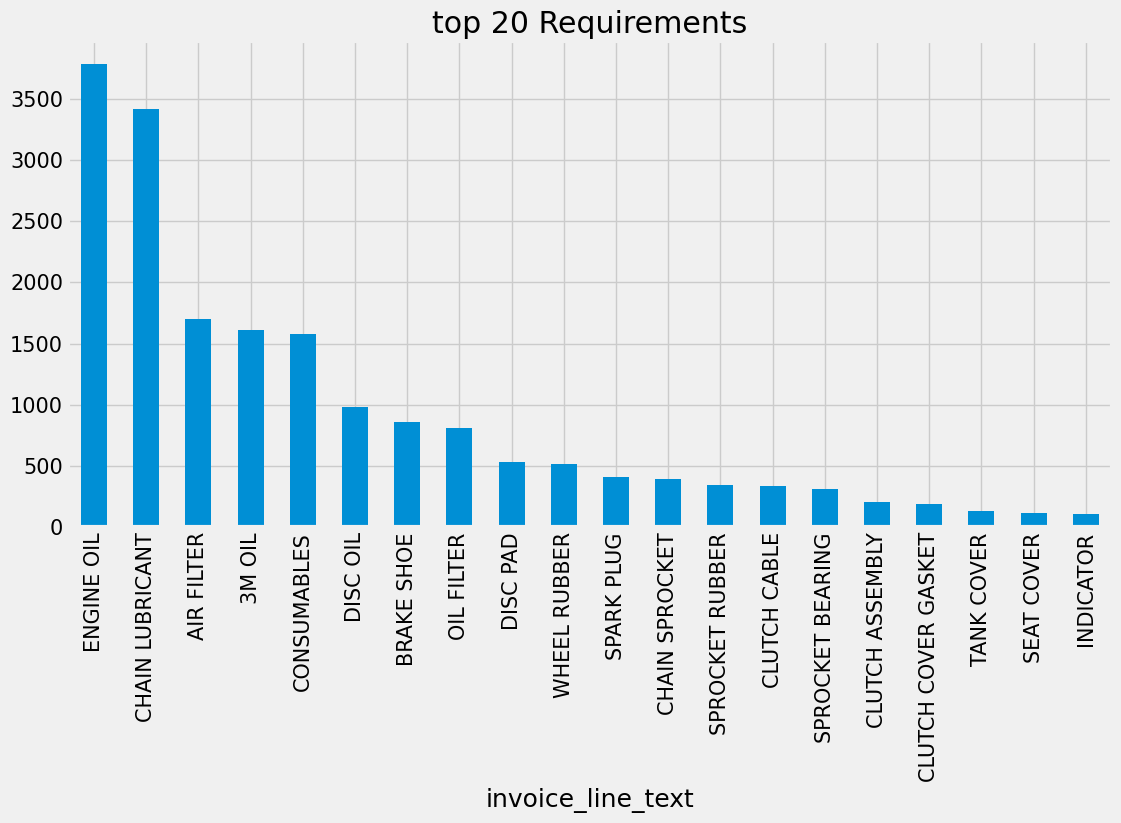

In [41]:
df2['invoice_line_text'].value_counts().nlargest(20).plot(kind='bar', title="top 20 Requirements", figsize=(12,6));

## 6. Analysis of Target Variable with respect to other factors

In [42]:
df1[['vehicle_model', 'invoice_line_text']].groupby('vehicle_model').describe()

invoice_line_text                              
                                     count unique              top  freq
vehicle_model                                                           
BAJAJ AVENGER STREET                   872     86       ENGINE OIL   171
BAJAJ AVENGER STREET 180                99      9      CONSUMABLES    23
BAJAJ AVENGER STREET 220              3358    177       ENGINE OIL   588
BAJAJ BOXER CT                           1      1       SPARK PLUG     1
BAJAJ CALIBER                           30     19       ENGINE OIL     5
BAJAJ CT 100                          1172     63       ENGINE OIL   241
BAJAJ DISCOVER                         535     98       ENGINE OIL    82
BAJAJ DISCOVER 125                    1111    118       ENGINE OIL   168
BAJAJ DISCOVER 135                      94     39       ENGINE OIL    13
BAJAJ DISCOVER 150                     223     57       ENGINE OIL    36
BAJAJ DOMINAR 400 ABS                    6      6       OIL FILTER     1
BAJAJ PLATINA                          706     56       ENGINE OIL   127
BAJAJ PULSAR 150                      6971    250       ENGINE OIL  1059
BAJAJ PULSAR 180                      1840    144       ENGINE OIL   302
BAJAJ PULSAR 220                      2115    176       ENGINE OIL   335
BAJAJ PULSAR AS 200                    324     72       ENGINE OIL    46
BAJAJ PULSAR LS135                     419     71       ENGINE OIL    53
BAJAJ PULSAR NS 160                    314     35  CHAIN LUBRICANT    58
BAJAJ PULSAR NS 200                   1808    116       ENGINE OIL   296
BAJAJ PULSAR RS 200                    249     38       ENGINE OIL    44
BAJAJ V                                 43     17       ENGINE OIL     9
BAJAJ V125                              78     15  CHAIN LUBRICANT    15
BAJAJ V15                               17      9       ENGINE OIL     3
BAJAJ V150                             564     45       ENGINE OIL    97
BAJAJ WIND 125                           4      4  CHAIN LUBRICANT     1
BAJAJ XCD 125                           21     10       ENGINE OIL     5
BAJAJ XCD 135                           10      7       ENGINE OIL     2
WAVE                                     8      8       ENGINE OIL     1

In [43]:
df1.groupby(['vehicle_model', 'invoice_line_text']).size().nlargest(15)

vehicle_model             invoice_line_text
BAJAJ PULSAR 150          ENGINE OIL           1059
                          CHAIN LUBRICANT       962
BAJAJ AVENGER STREET 220  ENGINE OIL            588
BAJAJ PULSAR 150          AIR FILTER            546
BAJAJ AVENGER STREET 220  CHAIN LUBRICANT       537
BAJAJ PULSAR 150          3M OIL                396
                          CONSUMABLES           382
                          BRAKE SHOE            348
BAJAJ PULSAR 220          ENGINE OIL            335
BAJAJ PULSAR 150          DISC OIL              320
BAJAJ PULSAR 180          ENGINE OIL            302
BAJAJ AVENGER STREET 220  AIR FILTER            300
BAJAJ PULSAR 220          CHAIN LUBRICANT       296
BAJAJ PULSAR NS 200       ENGINE OIL            296
                          CHAIN LUBRICANT       287
dtype: int64

In [44]:
df1[['business_partner_name','vehicle_model','invoice_line_text']].groupby(['business_partner_name','vehicle_model']).describe().head(50)

invoice_line_text         \
                                                           count unique   
business_partner_name vehicle_model                                       
A J XXXXXXXXXX        BAJAJ PULSAR 180                        17      9   
A VEXXXXXXXXXX        BAJAJ PULSAR NS 200                     19     10   
A jyXXXXXXXXXX        BAJAJ PULSAR NS 200                      5      5   
A suXXXXXXXXXX        BAJAJ PULSAR RS 200                      6      6   
ABHIXXXXXXXXXX        BAJAJ AVENGER STREET 220                 4      4   
                      BAJAJ PULSAR 150                         2      2   
                      BAJAJ PULSAR 180                        29     27   
                      BAJAJ PULSAR AS 200                     14     12   
                      BAJAJ PULSAR NS 200                      6      5   
ABIRXXXXXXXXXX        BAJAJ PULSAR NS 200                      9      7   
ABISXXXXXXXXXX        BAJAJ AVENGER STREET 220                 6      6   
ADHIXXXXXXXXXX        BAJAJ PULSAR 150                        12     12   
ADITXXXXXXXXXX        BAJAJ AVENGER STREET 220                 7      6   
                      BAJAJ PULSAR 150                         5      5   
                      BAJAJ PULSAR 180                         9      9   
ADIVXXXXXXXXXX        BAJAJ PULSAR 150                        20     11   
AISHXXXXXXXXXX        BAJAJ PULSAR 150                         5      5   
AJAYXXXXXXXXXX        BAJAJ AVENGER STREET 220                 8      8   
                      BAJAJ PULSAR 150                         6      5   
AJOSXXXXXXXXXX        BAJAJ PULSAR 150                        14      8   
AKSAXXXXXXXXXX        BAJAJ PULSAR 150                         4      4   
AKSHXXXXXXXXXX        BAJAJ AVENGER STREET 220                 5      5   
ALOKXXXXXXXXXX        BAJAJ CT 100                            24     15   
AMALXXXXXXXXXX        BAJAJ PULSAR NS 200                      5      5   
AMITXXXXXXXXXX        BAJAJ DISCOVER 125                       5      5   
                      BAJAJ PULSAR 150                         5      5   
                      BAJAJ V150                              14      6   
AMOLXXXXXXXXXX        BAJAJ AVENGER STREET 220                36     16   
ANANXXXXXXXXXX        BAJAJ PULSAR 150                        11      7   
                      BAJAJ PULSAR NS 200                     42     22   
ANILXXXXXXXXXX        BAJAJ PULSAR 150                        73     42   
                      BAJAJ PULSAR 180                        16      8   
ANIMXXXXXXXXXX        BAJAJ PULSAR LS135                       4      4   
ANISXXXXXXXXXX        BAJAJ AVENGER STREET 220                 5      5   
                      BAJAJ PULSAR 150                         4      4   
ANJAXXXXXXXXXX        BAJAJ PULSAR 220                        19     12   
ANKIXXXXXXXXXX        BAJAJ PULSAR 180                         3      3   
ANKUXXXXXXXXXX        BAJAJ AVENGER STREET                    12      9   
ANMOXXXXXXXXXX        BAJAJ PULSAR 180                         4      4   
ANOOXXXXXXXXXX        BAJAJ AVENGER STREET 220                18     13   
ANSUXXXXXXXXXX        BAJAJ AVENGER STREET 220                11      8   
ARBIXXXXXXXXXX        BAJAJ DISCOVER                          16     15   
ARPIXXXXXXXXXX        BAJAJ DISCOVER                           5      5   
ARUNXXXXXXXXXX        BAJAJ CT 100                             5      5   
                      BAJAJ PULSAR NS 200                     13      8   
                      BAJAJ PULSAR RS 200                      4      4   
ARVIXXXXXXXXXX        BAJAJ V150                               7      7   
ASHOXXXXXXXXXX        BAJAJ AVENGER STREET 220                11      7   
                      BAJAJ PULSAR AS 200                      9      9   
ASHUXXXXXXXXXX        BAJAJ DISCOVER 150                      15     12   

                                                                      


In [45]:
df1.groupby(['business_partner_name','vehicle_model','invoice_line_text']).size().nlargest(15)

business_partner_name  vehicle_model             invoice_line_text
shivXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           19
venkXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           18
shivXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      17
venkXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      16
prasXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           15
abhiXXXXXXXXXX         BAJAJ AVENGER STREET 220  ENGINE OIL           14
hariXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
sathXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
srinXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE OIL           14
abhiXXXXXXXXXX         BAJAJ AVENGER STREET 220  CHAIN LUBRICANT      13
hariXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      13
prasXXXXXXXXXX         BAJAJ PULSAR 150          CHAIN LUBRICANT      13
dineXXXXXXXXXX         BAJAJ PULSAR 150          ENGINE O

- we are not getting required information with business partner name.
- So, We will continue our code with respect to vehicle model.

In [46]:
# Now we will create a new df in which we will have 3 important columns which gives maximum information of the dataset.

In [30]:
pd.reset_option('display.max_rows')

In [31]:
df4 = df1[['job_card_date', 'vehicle_model', 'invoice_line_text']]
df4.set_index('job_card_date', inplace = True)
df4

,vehicle_model,invoice_line_text
job_card_date,,
2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL
2017-05-31,BAJAJ PULSAR NS 200,CHAIN LUBRICANT
...,...,...
2019-01-06,BAJAJ DISCOVER 125,SPROCKET RUBBER
2019-01-06,BAJAJ DISCOVER 125,CLUTCH CABLE
2019-01-06,BAJAJ DISCOVER 125,OIL FILTER


In [32]:
models = ['BAJAJ PULSAR 150','BAJAJ AVENGER STREET 220','BAJAJ PULSAR 220','BAJAJ PULSAR 180','BAJAJ PULSAR NS 200']
labels =['ENGINE OIL','CHAIN LUBRICANT','AIR FILTER','3M OIL','CONSUMABLES','BRAKE SHOE','DISC OIL']
Vehicle_Spares = []
for model in models:
    for text in labels:
        filename=(model.replace(' ','_'))+'_'+(text.replace(' ','_'))
        tempDf=df4.loc[(df4['vehicle_model']==model)&(df4['invoice_line_text']==text)]
        tempDf=tempDf['invoice_line_text'].resample('W').count().to_frame()
        colname=filename+'_'+'Weekly_Count'
        tempDf = tempDf.rename(columns={'invoice_line_text':colname})
        Vehicle_Spares.append(tempDf)
        tempDf.to_csv(filename + '.csv')

In [33]:
Vehicle_Spares[0]

,BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


## 7. Time Series Implementation

- We will showcase time series forecasting for 2 parts and rest of them will follow the same procedure. From our analysis with respect to vehicle model we can see the engine oil and chain lubricant for bajaj pulsar 150 bike are the most ordered parts, so we will be forecasting them.

In [96]:
BAJAJPULSAR150EngineOilWeeklyCount = Vehicle_Spares[0].copy()
BAJAJPULSAR150EngineOilWeeklyCount

,BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


In [103]:
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = Vehicle_Spares[1].copy()
BAJAJPULSAR150EngineOilWeeklyCount

job_card_date
2017-06-04     6
2017-06-11    13
2017-06-18    14
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    15
2018-12-16    12
2018-12-23    15
2018-12-30    21
2019-01-06    15
Freq: W-SUN, Name: BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count, Length: 84, dtype: int64

In [97]:
# To convert it to Series
BAJAJPULSAR150EngineOilWeeklyCount = BAJAJPULSAR150EngineOilWeeklyCount.squeeze()
BAJAJPULSAR150EngineOilWeeklyCount

job_card_date
2017-06-04     6
2017-06-11    13
2017-06-18    14
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    15
2018-12-16    12
2018-12-23    15
2018-12-30    21
2019-01-06    15
Freq: W-SUN, Name: BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count, Length: 84, dtype: int64

In [106]:
# To convert it to Series
BAJAJPULSAR150CHAINLUBRICANTWeeklyCount = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.squeeze()
BAJAJPULSAR150EngineOilWeeklyCount

job_card_date
2017-06-04     6
2017-06-11    13
2017-06-18    14
2017-06-25    13
2017-07-02    11
              ..
2018-12-09    15
2018-12-16    12
2018-12-23    15
2018-12-30    21
2019-01-06    15
Freq: W-SUN, Name: BAJAJ_PULSAR_150_ENGINE_OIL_Weekly_Count, Length: 84, dtype: int64

In [98]:
# Checking stationarity
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [99]:
check_stationarity(BAJAJPULSAR150EngineOilWeeklyCount)

The series is stationary


<Axes: xlabel='job_card_date'>

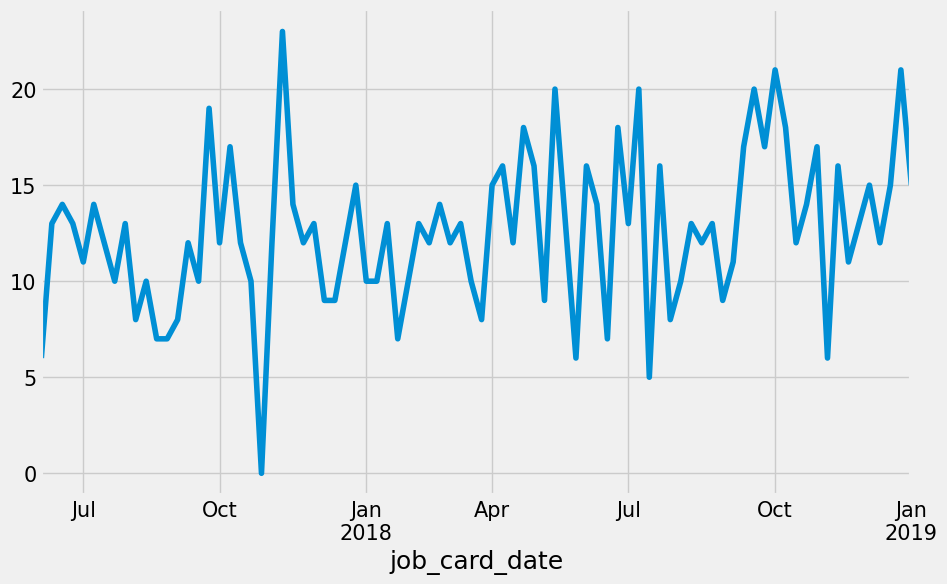

In [100]:
BAJAJPULSAR150EngineOilWeeklyCount.plot()

## 8. Checking Autocorrelation and Partial Autocorrelation

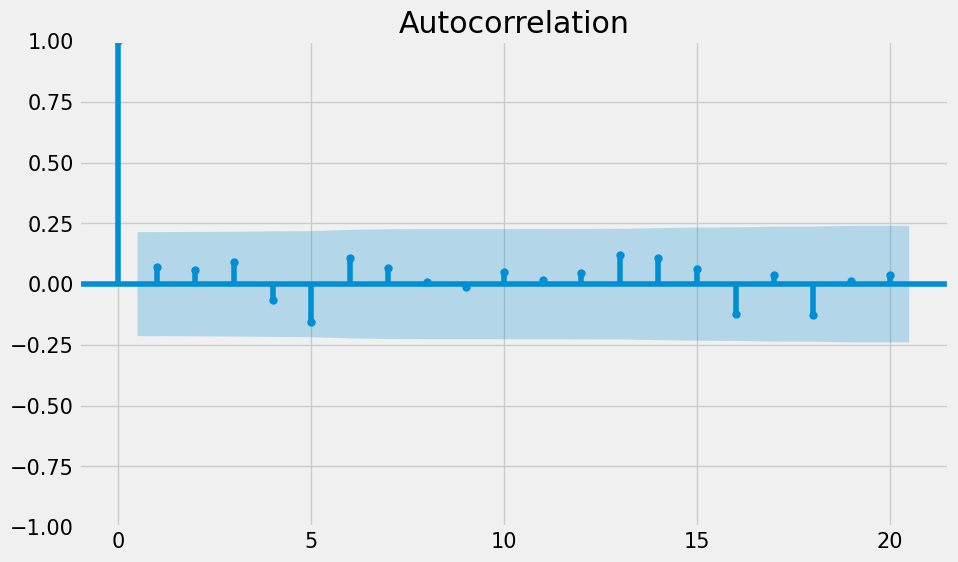

In [56]:
plot_acf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show()

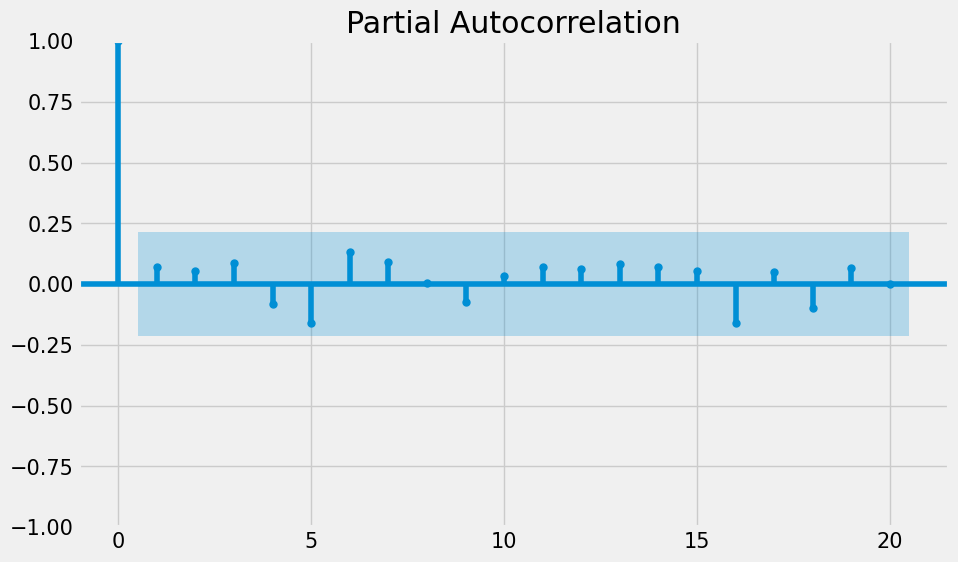

In [57]:
plot_pacf(BAJAJPULSAR150EngineOilWeeklyCount)
plt.show()

## 9. Checking for Seasonality

## 10. Finding Period

In [38]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

In [39]:
find_period(BAJAJPULSAR150EngineOilWeeklyCount)

6

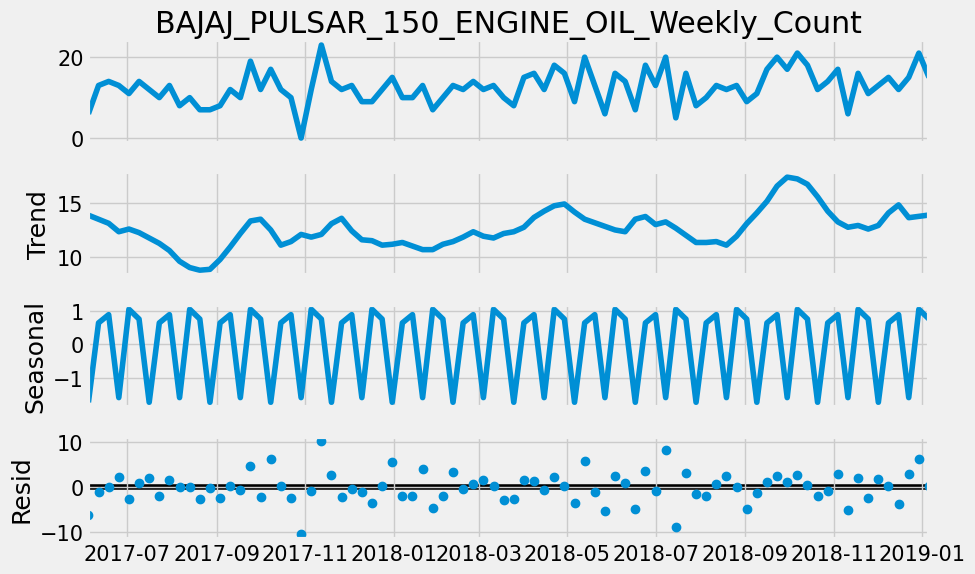

In [40]:
result = seasonal_decompose(BAJAJPULSAR150EngineOilWeeklyCount, model='additive',extrapolate_trend='freq',period=6)
result.plot()
plt.show()

The series is stationary


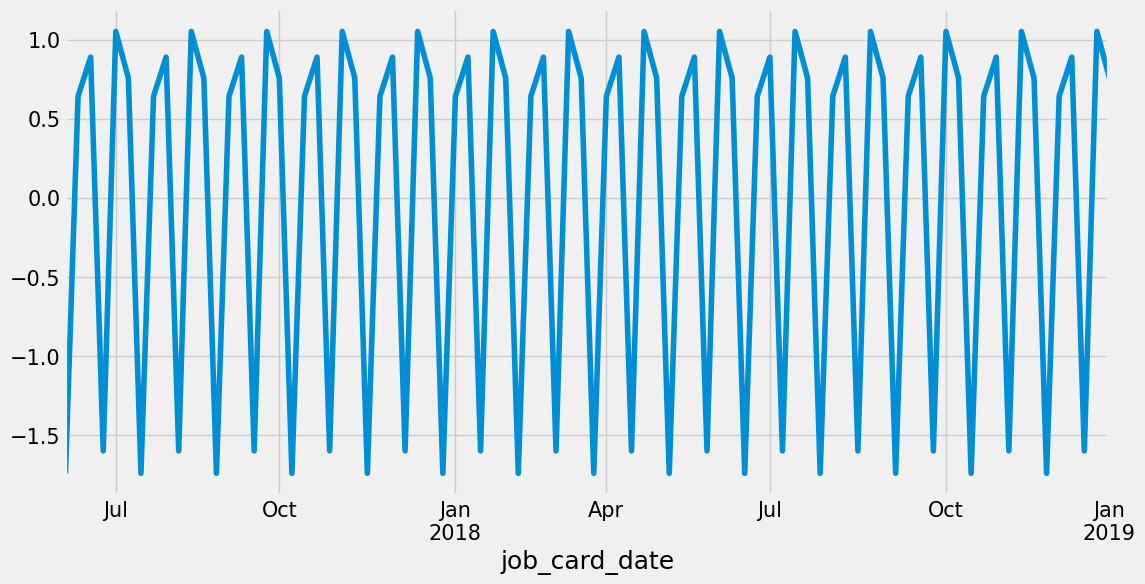

In [41]:
seasonal = result.seasonal
seasonal.plot(figsize=(12,6))
check_stationarity(seasonal)

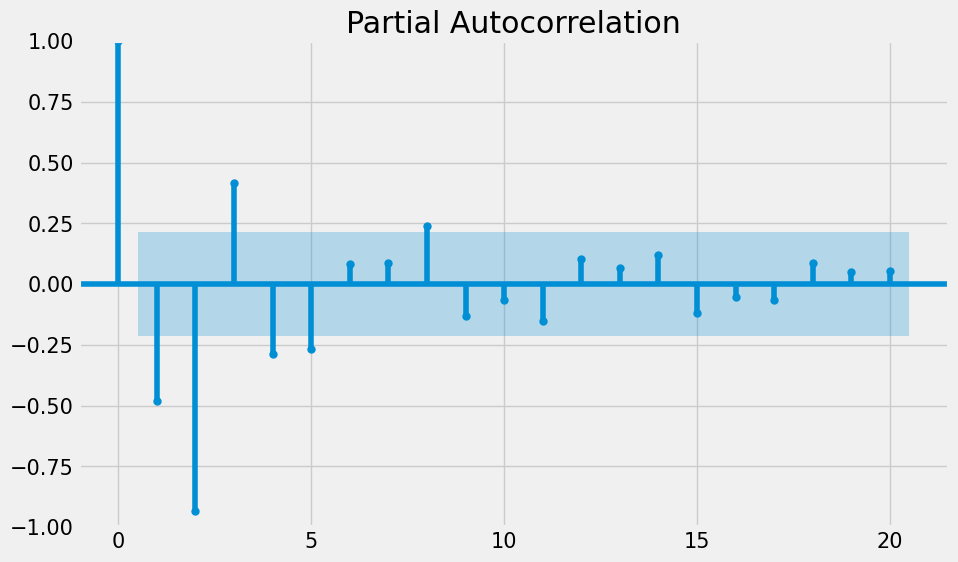

In [62]:
plot_pacf(seasonal)
plt.show()

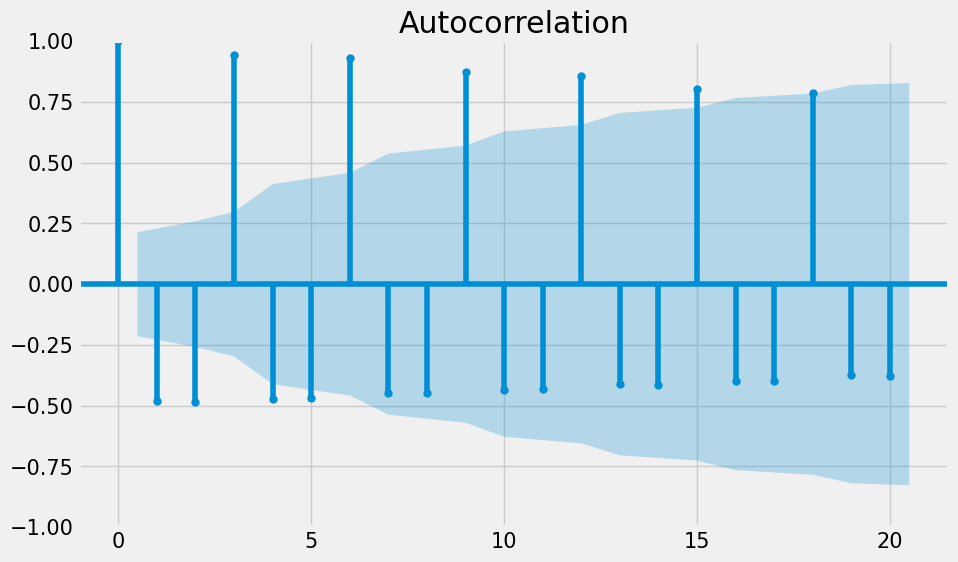

In [63]:
plot_acf(seasonal)
plt.show()

## 11. Creating train and test

In [42]:
train=BAJAJPULSAR150EngineOilWeeklyCount[:69]
test=BAJAJPULSAR150EngineOilWeeklyCount[69:]

In [43]:
train.shape

(69,)

## 12. Modelling

### Accuracy Metrics¶

In [44]:
def forecast_accuracy(model,forecast, actual):
    AIC = model.aic
    MAD = np.mean(np.abs(forecast - actual))
    MSE = np.mean((forecast - actual)**2)
    RMSE = np.mean((forecast - actual)**2)**.5
    MAPE = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    return({'AIC': AIC,'MAD': MAD, 'MSE': MSE ,'RMSE': RMSE, 'MAPE': MAPE})

### Naive Model

In [45]:
base = BAJAJPULSAR150EngineOilWeeklyCount.copy()
base = base.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
base

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count
job_card_date,
2017-06-04,6
2017-06-11,13
2017-06-18,14
2017-06-25,13
2017-07-02,11
...,...
2018-12-09,15
2018-12-16,12
2018-12-23,15


In [46]:
base_diff = pd.concat([base,base.shift(1)],axis=1)

In [47]:
base_diff

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,BAJAJPULSAR150_ENGINEOIL_Weekly_Count
job_card_date,,
2017-06-04,6,NaN
2017-06-11,13,6.0
2017-06-18,14,13.0
2017-06-25,13,14.0
2017-07-02,11,13.0
...,...,...
2018-12-09,15,13.0
2018-12-16,12,15.0
2018-12-23,15,12.0


In [48]:
base_diff.columns = ['Actual_Count','Forecast_Count']

In [49]:
base_diff.dropna(inplace=True)

### Evaluation

In [50]:
MAD = np.mean(np.abs(base_diff.Forecast_Count - base_diff.Actual_Count))
MSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)
RMSE = np.mean((base_diff.Forecast_Count - base_diff.Actual_Count)**2)**.5
print('Mean Absolute Deviation of Naive Model is: ',MAD)
print('Mean Squared Error of Naive Model is: ',MSE)
print('Root Mean Squared Error of Naive Model is: ',RMSE)

Mean Absolute Deviation of Naive Model is:  4.469879518072289
Mean Squared Error of Naive Model is:  30.83132530120482
Root Mean Squared Error of Naive Model is:  5.552596266721075


## ARIMA model

In [51]:
model_arima = ARIMA(train, order=(1,0,1))
model_arima_fit = model_arima.fit()

In [52]:
predictions = model_arima_fit.forecast(steps=15)
predictions

2018-09-30    11.444014
2018-10-07    11.634985
2018-10-14    11.770420
2018-10-21    11.866469
2018-10-28    11.934586
2018-11-04    11.982894
2018-11-11    12.017153
2018-11-18    12.041449
2018-11-25    12.058680
2018-12-02    12.070900
2018-12-09    12.079566
2018-12-16    12.085712
2018-12-23    12.090071
2018-12-30    12.093162
2019-01-06    12.095354
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [53]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 394.24413009223036,
 'MAD': 3.870511711186082,
 'MSE': 23.031217314157725,
 'RMSE': 4.799085049689964,
 'MAPE': 26.694916994731155}

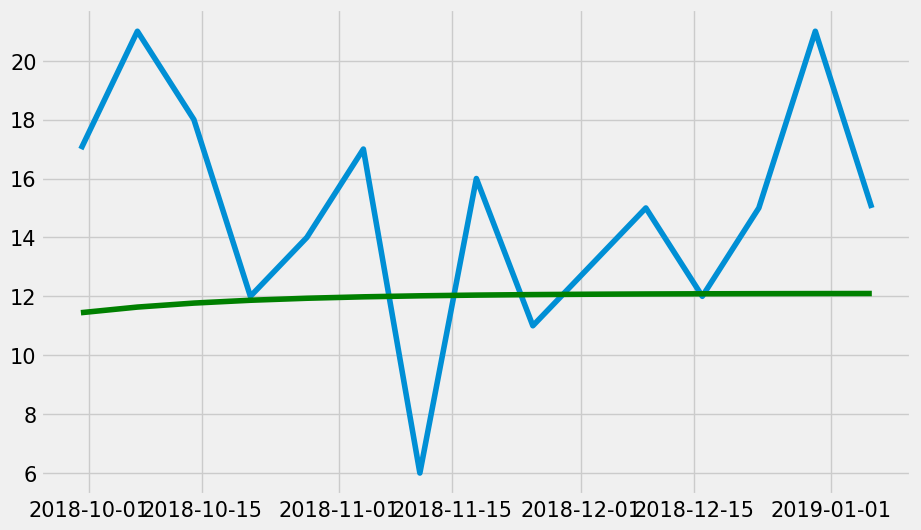

In [54]:
plt.plot(test)
plt.plot(predictions,color='green')

## HYPERPARAMETER TUNING ARIMA

AIC and RMSE are inter-related but they represent different objectives in choosing the best model. RMSE/MAPE are measures of error and disregards the "complexity" of the model. Optimizing for RMSE/MAPE can give you accurate results, but could lead to overly complex model. It ultimately comes down to the purpose of your model. If having the most accurate prediction matters then you might simply look at RMSE/MAPE, but if you need a model that is more interpretable/explainable then you might want to consider AIC which better balances complexity and accuracy. Here i am looking more into accuracy and will be modelling based on RMSE.


In [55]:
p=q=range(0,6)
d=range(0,2)
pdq = list(itertools.product(p,d,q))
arima_metric_dict = dict()

In [56]:
for params in pdq:
    try:
        model_arima = ARIMA(train, order=params,)
        model_arima_fit = model_arima.fit()
        pred = model_arima_fit.forecast(steps=15)
        rmse = np.sqrt(mean_squared_error(test,pred))
        arima_metric_dict.update({(params):[model_arima_fit.aic,rmse]})
    except:
        continue

In [57]:
arima_aic_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][0])}
arima_aic_sorted_results_top10 = dict(list(arima_aic_sorted_results.items())[0: 10])
arima_aic_sorted_results_df_top10 = pd.DataFrame(arima_aic_sorted_results_top10)
arima_aic_sorted_results_df_top10 = arima_aic_sorted_results_df_top10.T
arima_aic_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_aic_sorted_results_df_top10

AIC      RMSE
0 1 1  390.163082  4.391249
  0 0  390.813479  4.642062
  1 2  392.149753  4.393141
1 1 1  392.151410  4.392636
0 0 1  392.793713  4.652990
1 0 0  392.796215  4.651196
2 1 2  392.910639  4.003793
1 1 3  392.931694  4.011065
0 1 3  393.836327  4.480080
2 1 1  393.917579  4.457070

In [58]:
arima_rmse_sorted_results = {k:v for k,v in sorted(arima_metric_dict.items(),key=lambda x: x[1][1])}
arima_rmse_sorted_results_top10 = dict(list(arima_rmse_sorted_results.items())[0: 10])
arima_rmse_sorted_results_df_top10 = pd.DataFrame(arima_rmse_sorted_results_top10)
arima_rmse_sorted_results_df_top10 = arima_rmse_sorted_results_df_top10.T
arima_rmse_sorted_results_df_top10.columns = ['AIC','RMSE']
arima_rmse_sorted_results_df_top10

AIC      RMSE
5 1 0  404.184219  3.730141
2 1 2  392.910639  4.003793
1 1 3  392.931694  4.011065
4 1 0  409.330817  4.048847
3 1 4  398.873838  4.114700
4 1 5  402.303914  4.126976
2 1 4  396.954344  4.131229
3 1 0  407.762521  4.141513
5 1 3  398.300793  4.356175
    4  400.290025  4.361242

In [59]:
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()

In [60]:
prediction = model_arima_fit.forecast(steps=15)
prediction

2018-09-30    14.302006
2018-10-07    14.929288
2018-10-14    13.919709
2018-10-21    13.814980
2018-10-28    15.158437
2018-11-04    16.251583
2018-11-11    14.797879
2018-11-18    15.043999
2018-11-25    14.841395
2018-12-02    14.672783
2018-12-09    14.948887
2018-12-16    15.310894
2018-12-23    14.930710
2018-12-30    15.009111
2019-01-06    14.983485
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [61]:
forecast_accuracy(model_arima_fit,predictions,test)

{'AIC': 404.1842189994205,
 'MAD': 3.870511711186082,
 'MSE': 23.031217314157725,
 'RMSE': 4.799085049689964,
 'MAPE': 26.694916994731155}

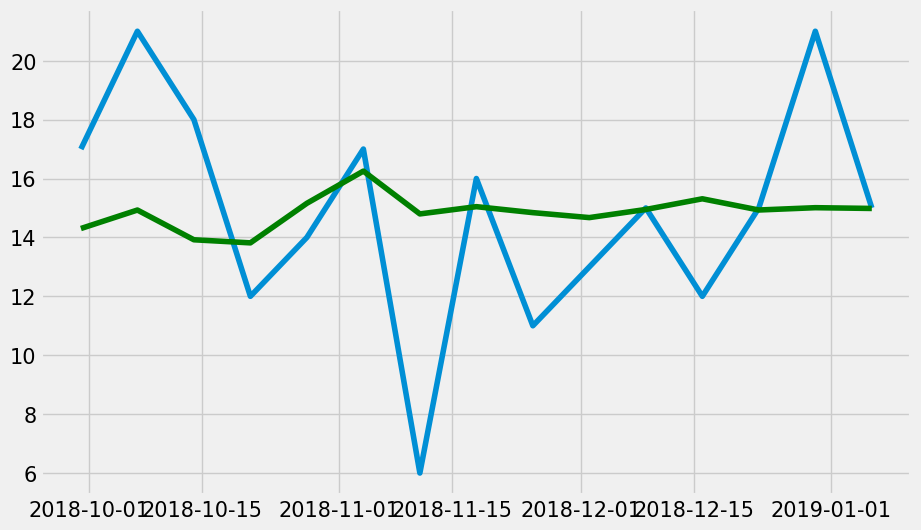

In [62]:
plt.plot(test)
plt.plot(prediction,color='green')

## ARIMA

In [63]:
model = SARIMAX(train, order=(1,0,1), seasonal_order=(2,0,3,9), enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

## Evaluation

In [64]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 235.80636972274195,
 'MAD': 3.080767169024199,
 'MSE': 14.891677164808057,
 'RMSE': 3.8589735895452897,
 'MAPE': 24.54896863075105}

<Axes: xlabel='job_card_date'>

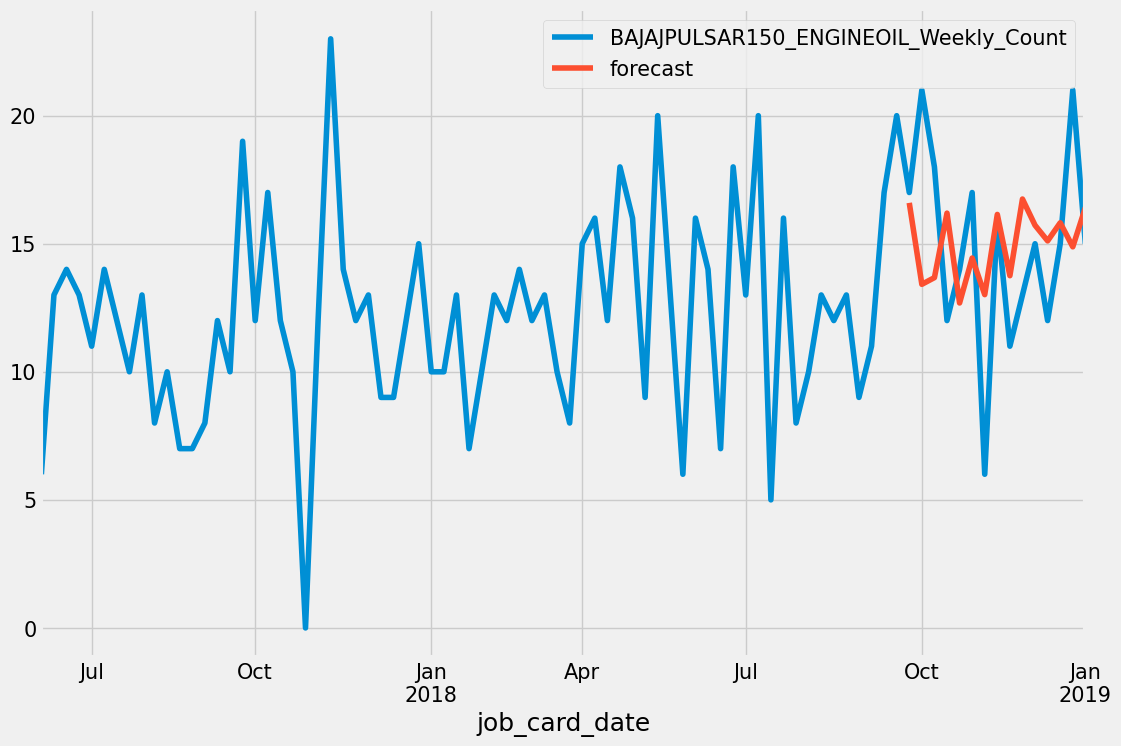

In [65]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

## Future Forecasting

In [66]:
# Predicting for the next 3 Months.
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<Axes: >

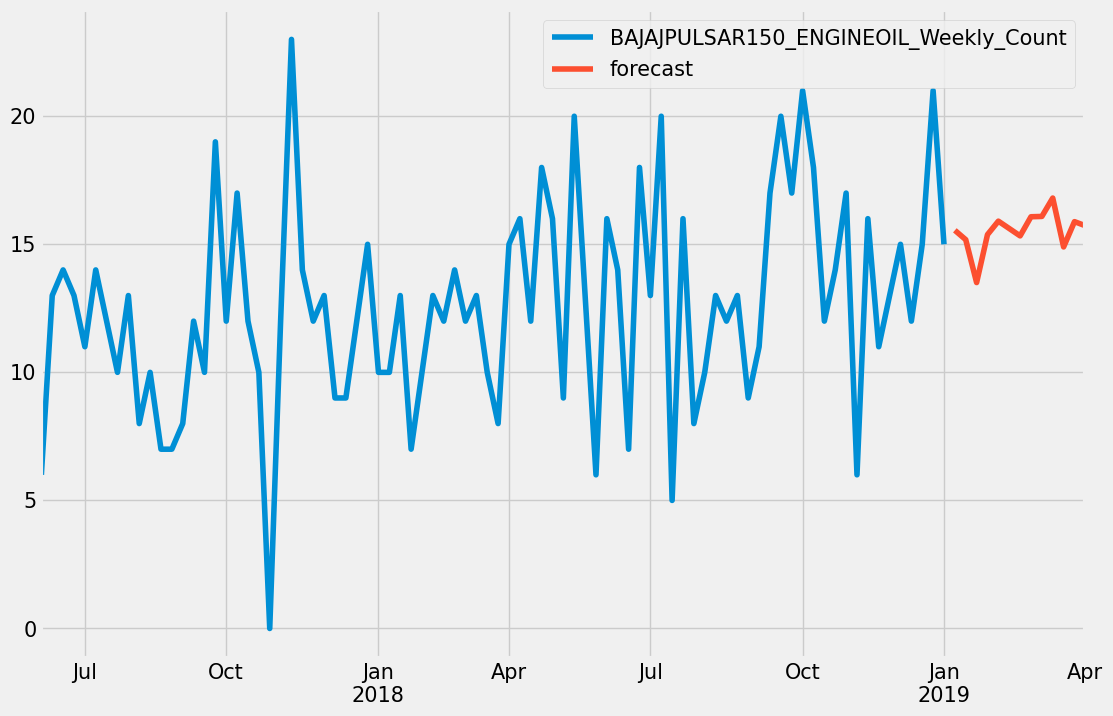

In [67]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

## Hyper parameter tuning sarima

In [68]:
p=q=range(0,6)
d=range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]
print('Example of param combo for SARIMA: ')
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX : {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX : {} x {}'.format(pdq[2],seasonal_pdq[4]))
print('SARIMAX : {} x {}'.format(pdq[3],seasonal_pdq[5]))

Example of param combo for SARIMA: 
SARIMAX : (0, 0, 1) x (0, 0, 1, 6)
SARIMAX : (0, 0, 1) x (0, 0, 2, 6)
SARIMAX : (0, 0, 2) x (0, 0, 3, 6)
SARIMAX : (0, 0, 2) x (0, 0, 4, 6)
SARIMAX : (0, 0, 3) x (0, 0, 5, 6)


In [70]:
# It will take lots of time arount 5000+ seconds.
metric_dict = dict()
for pm in pdq:
    for seasonal_pm in seasonal_pdq:
        try:
            model = SARIMAX(train,order=pm,seasonal_order=seasonal_pm,enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit()
            y_predicted = results.predict(start=69,end=84,dynamic=False)
            y_true = test
            mse = ((y_predicted - y_true)**2).mean()
            rmse = np.sqrt(mse)
            metric_dict.update({(pm,seasonal_pm):[results.aic,rmse]})
        except:
            continue

- it will take lots of time to run somewhere around 5000+ seconds

In [71]:
sorted_results_aic = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][0])}
sorted_results_aic_top10 = dict(list(sorted_results_aic.items())[0: 10])
sorted_results_aic_df_top10 = pd.DataFrame(sorted_results_aic_top10)
sorted_results_aic_df_top10 = sorted_results_aic_df_top10.T
sorted_results_aic_df_top10.columns = ['AIC','RMSE']
sorted_results_aic_df_top10

AIC          RMSE
(1, 0, 3) (0, 0, 3, 6)  16.0  1.716491e+14
(2, 0, 2) (0, 1, 3, 6)  16.0  1.121692e+33
(2, 1, 2) (0, 1, 3, 6)  16.0  5.977499e+29
(2, 0, 2) (1, 1, 3, 6)  18.0  1.047057e+34
(2, 1, 2) (1, 1, 3, 6)  18.0  3.175258e+30
(3, 0, 2) (0, 1, 3, 6)  18.0  8.987780e+32
(3, 1, 2) (0, 0, 3, 6)  18.0  1.274236e+66
          (0, 1, 3, 6)  18.0  4.800992e+71
(1, 0, 5) (0, 0, 3, 6)  20.0  4.073746e+11
(2, 0, 2) (2, 1, 3, 6)  20.0  2.246442e+33

In [72]:
sorted_results_rmse = {k:v for k,v in sorted(metric_dict.items(),key=lambda x: x[1][1])}
sorted_results_rmse_top10 = dict(list(sorted_results_rmse.items())[0: 10])
sorted_results_rmse_df_top10 = pd.DataFrame(sorted_results_rmse_top10)
sorted_results_rmse_df_top10 = sorted_results_rmse_df_top10.T
sorted_results_rmse_df_top10.columns = ['AIC','RMSE']
sorted_results_rmse_df_top10

,,AIC,RMSE
"(1, 1, 4)","(5, 0, 2, 6)",221.883573,3.032088
"(4, 1, 5)","(5, 0, 1, 6)",213.210458,3.064380
"(3, 0, 5)","(3, 0, 5, 6)",206.584743,3.087659
"(2, 1, 4)","(5, 0, 2, 6)",218.047416,3.093994
"(4, 1, 5)","(5, 0, 0, 6)",212.258400,3.145498
"(3, 1, 5)","(5, 0, 1, 6)",217.453254,3.147938
"(3, 1, 4)","(5, 0, 2, 6)",216.478917,3.164769
"(2, 1, 4)","(5, 0, 1, 6)",219.188497,3.168365
"(3, 1, 5)","(5, 0, 0, 6)",215.682373,3.178511
"(3, 0, 4)","(4, 0, 1, 6)",251.117056,3.191505


In [73]:
model = SARIMAX(train, order=(1,1,4), seasonal_order=(5,0,2,6),enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()

## Evaluation

In [74]:
y_predicted = results.predict(start=69,end=83,dynamic=False)
y_true = test.copy()
forecast_accuracy(results,y_predicted,y_true)

{'AIC': 221.88357335135245,
 'MAD': 2.5589278778755444,
 'MSE': 9.19356048410001,
 'RMSE': 3.0320884690424204,
 'MAPE': 20.290866449159804}

<Axes: xlabel='job_card_date'>

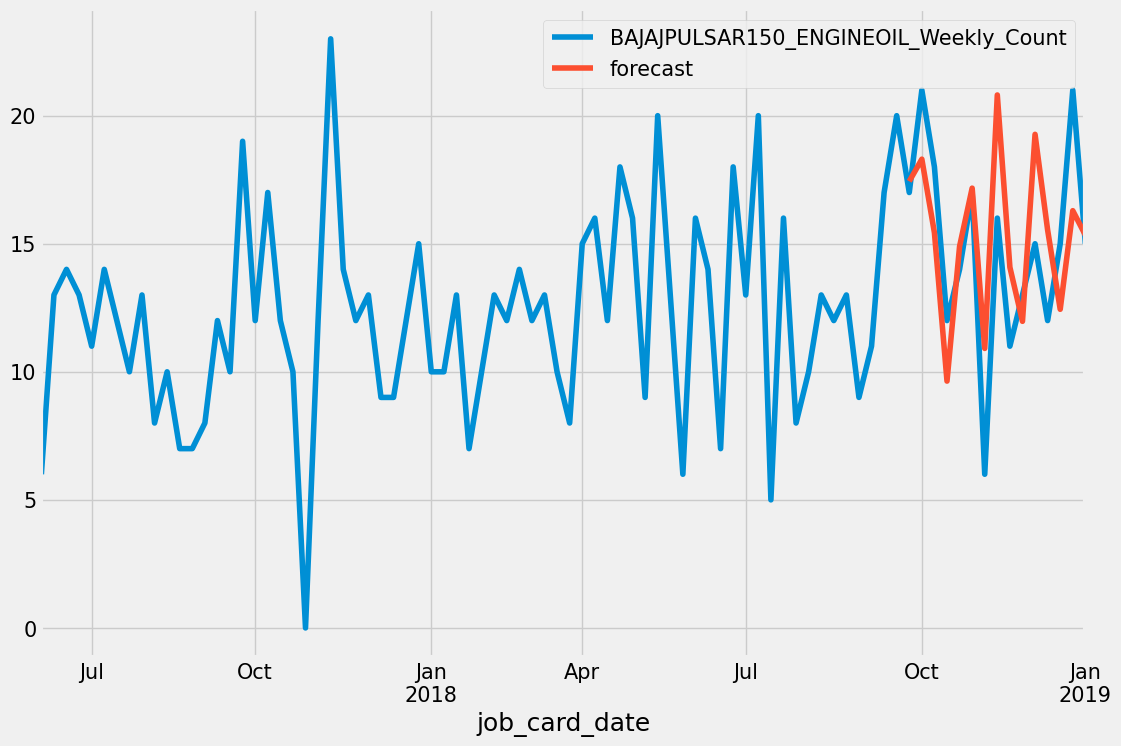

In [75]:
data = BAJAJPULSAR150EngineOilWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_ENGINEOIL_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count','forecast']].plot(figsize=(12,8))

## Future Forecasting

In [76]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_ENGINEOIL_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<Axes: >

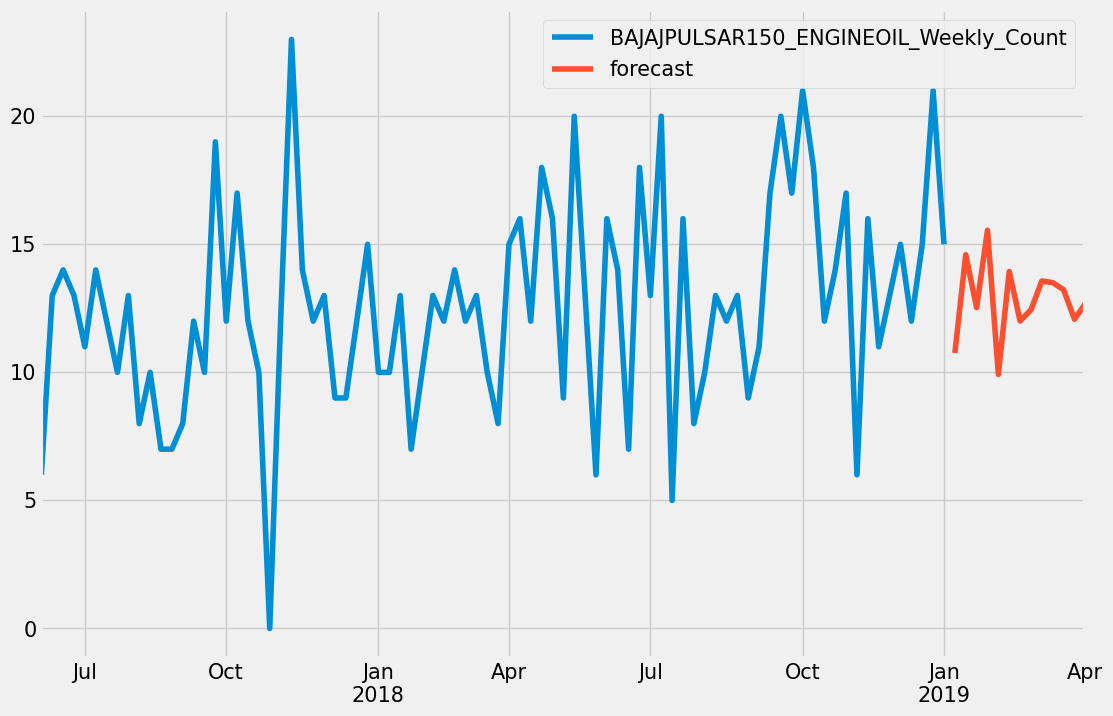

In [77]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)
data[['BAJAJPULSAR150_ENGINEOIL_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

## fbprophet

In [84]:
!pip install prophet

In [85]:
fb = Vehicle_Spares[0].copy()
fb.reset_index(inplace=True)
fb.columns = ['ds','y']

In [86]:
from prophet import Prophet
fb_train = fb[:69]
fb_test = fb[69:]

In [87]:
# Initialize the Model
fb_model=Prophet(interval_width=0.95,yearly_seasonality=True,seasonality_mode='additive')

In [88]:
fb_model.fit(fb_train)

19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:20 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
### Create future dates for test data
fb_future_dates=fb_model.make_future_dataframe(periods=fb_test.shape[0], freq='W')
fb_prediction=fb_model.predict(fb_future_dates)
fb_prediction[['ds','yhat','yhat_upper','yhat_lower']].tail()

,ds,yhat,yhat_upper,yhat_lower
79,2018-12-09,10.951242,17.140114,5.004721
80,2018-12-16,11.818738,17.399624,6.120421
81,2018-12-23,13.975095,20.110408,8.371671
82,2018-12-30,15.098698,21.086627,8.819518
83,2019-01-06,14.452474,20.070808,8.799332


<Axes: xlabel='ds'>

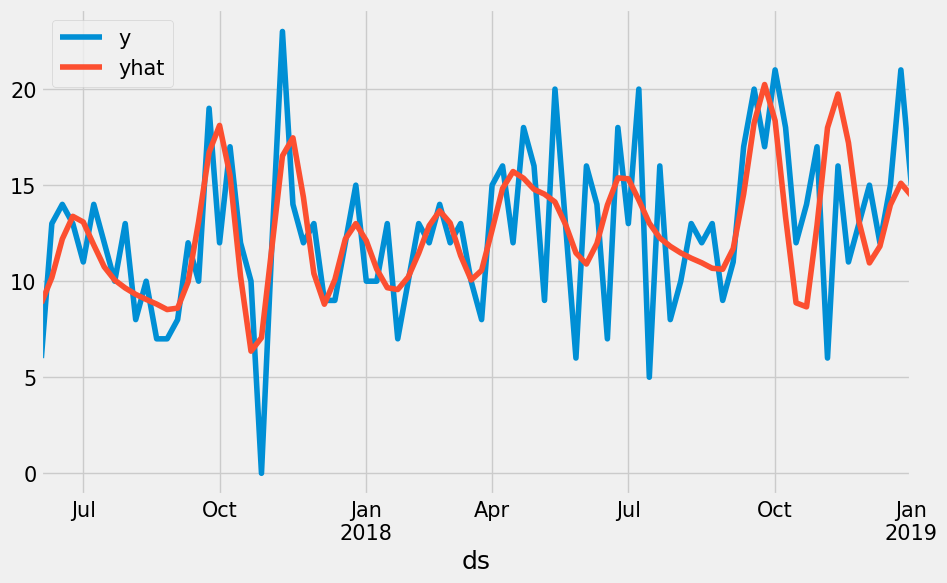

In [90]:
pd.concat([fb.set_index('ds')['y'],fb_prediction.set_index('ds')['yhat']],axis=1).plot()

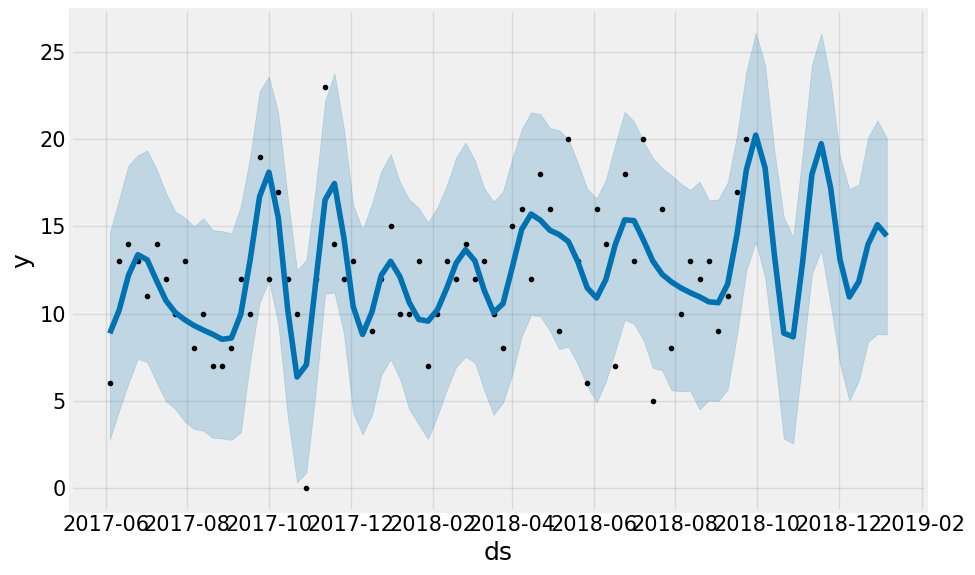

In [91]:
### plot the predicted projection
fb_model.plot(fb_prediction);

## Evaluation

In [92]:
from prophet.diagnostics import cross_validation
fb_cv = cross_validation(fb_model, initial='60 W', period='1 W', horizon = '3 W',disable_tqdm=True)
fb_cv.head()

19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-08-05,10.133809,4.028364,16.034774,10,2018-07-29
1,2018-08-12,8.926318,2.404699,15.250406,13,2018-07-29
2,2018-08-19,8.468888,2.345730,14.476559,12,2018-07-29
3,2018-08-12,8.879188,2.916569,15.529321,13,2018-08-05
4,2018-08-19,8.434238,2.265453,14.435920,12,2018-08-05


<Axes: xlabel='job_card_date'>

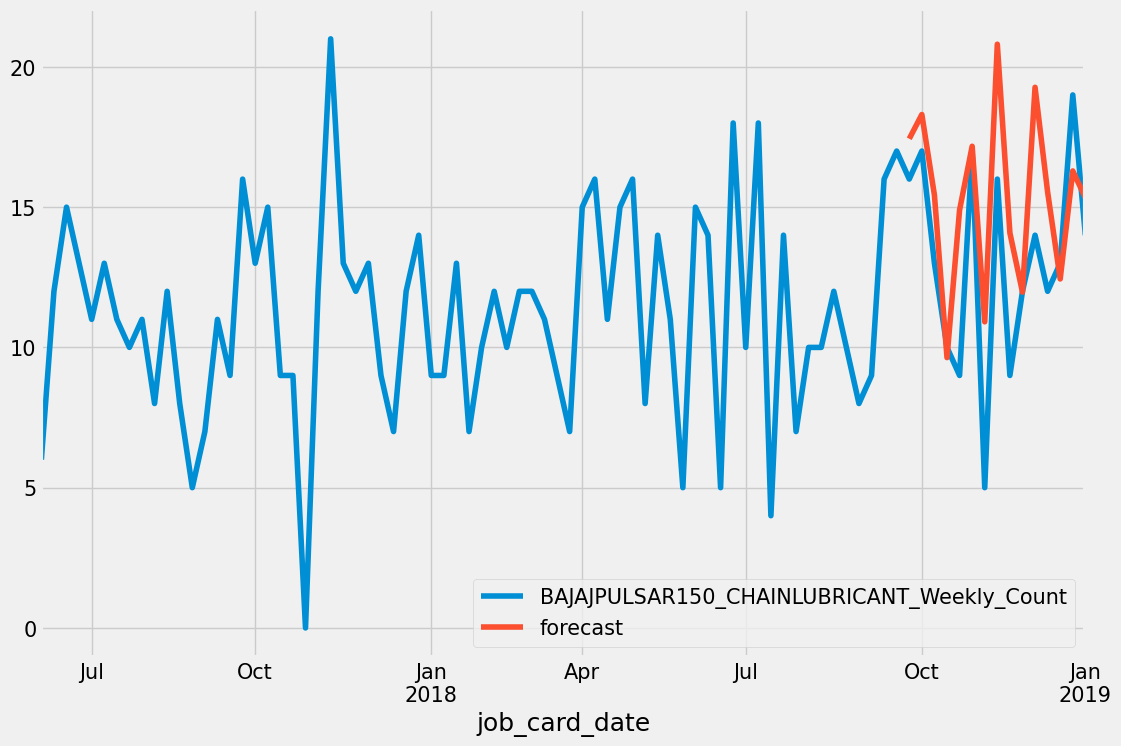

In [107]:
data = BAJAJPULSAR150CHAINLUBRICANTWeeklyCount.copy()
data = data.to_frame(name='BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count')
data['forecast']= results.predict(start=69,end=83,dynamic=False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count','forecast']].plot(figsize=(12,8))

## Future Forecast

In [108]:
pred_date=[data.index[-1]+ DateOffset(weeks=x)for x in range(0,14)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count,forecast
2019-01-13,NaN,NaN
2019-01-20,NaN,NaN
2019-01-27,NaN,NaN
2019-02-03,NaN,NaN
2019-02-10,NaN,NaN
2019-02-17,NaN,NaN
2019-02-24,NaN,NaN
2019-03-03,NaN,NaN
2019-03-10,NaN,NaN
2019-03-17,NaN,NaN


<Axes: >

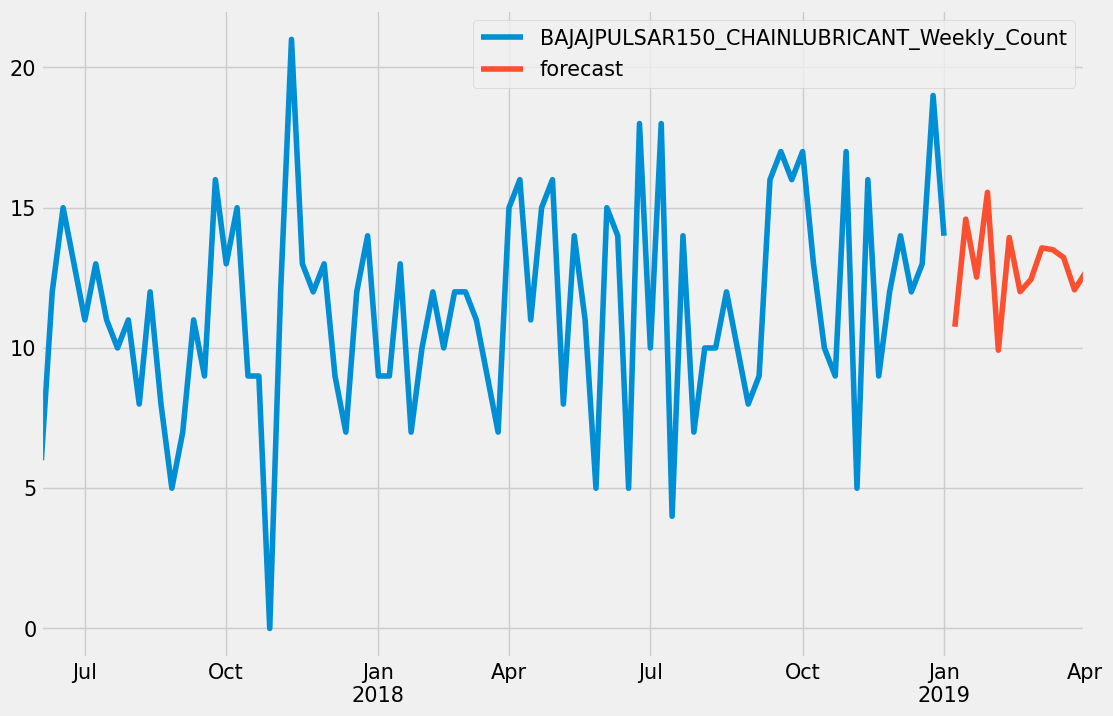

In [109]:
data=pd.concat([data,pred_date])
data['forecast'] = results.predict(start = 84, end = 97, dynamic= False)
data[['BAJAJPULSAR150_CHAINLUBRICANT_Weekly_Count', 'forecast']].plot(figsize=(12, 8))

### -> Conclusion - On the basis of visualization of the few models. SARIMA had peroformed well